In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

data prep

In [ ]:
electricityDf = pd.read_csv('/content/drive/MyDrive/PES/household_power_consumption.txt',
                            sep=';',
                            header=0,
                            parse_dates={'dt' : ['Date', 'Time']},
                            infer_datetime_format=True,
                            low_memory=False,
                            na_values=['nan','?'],
                            index_col='dt')

<ipython-input-3-e34ad9f770a3>:1: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  electricityDf = pd.read_csv('/content/drive/MyDrive/PES/household_power_consumption.txt',
<ipython-input-3-e34ad9f770a3>:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  electricityDf = pd.read_csv('/content/drive/MyDrive/PES/household_power_consumption.txt',
<ipython-input-3-e34ad9f770a3>:1: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  electricityDf = pd.read_csv('/content/drive/MyDrive/PES/household_power_consumption.txt',


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print(electricityDf.shape)
print(electricityDf.head())

(2075259, 7)
                     Global_active_power  Global_reactive_power  Voltage  \
dt                                                                         
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
dt                                                                      
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-16 17:28

In [ ]:
electricityDf.replace(['nan','?'], inplace=True)

<ipython-input-5-a6de281a0d94>:1: FutureWarning: DataFrame.replace without 'value' and with non-dict-like 'to_replace' is deprecated and will raise in a future version. Explicitly specify the new values instead.
  electricityDf.replace(['nan','?'], inplace=True)


In [ ]:
electricityDf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


In [ ]:
electricityDf.shape

(2075259, 7)

In [ ]:
# filling nan with mean in any columns
for j in range(0,7):
        electricityDf.iloc[:,j]=electricityDf.iloc[:,j].fillna(electricityDf.iloc[:,j].mean())

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        # forecast sequence (t, t+1, ... t+n)
        for i in range(0, n_out):
            cols.append(dff.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
# resampling of data over hour
df_resample = electricityDf.resample('D').mean()
df_resample.shape

(1442, 7)

In [ ]:
## If you would like to train based on the resampled data (over hour), then used below
values = df_resample.values


## full data without resampling
#values = df.values

# integer encode direction
# ensure all data is float
values = values.astype('float64')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.916786   0.130732   0.315385   0.928499   0.000000   0.163965   
2   0.694252   0.426671   0.550494   0.695226   0.181857   0.345776   
3   0.431901   0.234750   0.620518   0.424618   0.095088   0.216451   
4   0.313037   0.202322   0.667476   0.311508   0.075051   0.627798   
5   0.436748   0.232377   0.686364   0.428075   0.000000   0.218680   

   var7(t-1)   var1(t)   var2(t)   var3(t)   var4(t)   var5(t)   var6(t)  \
1   0.740357  0.694252  0.426671  0.550494  0.695226  0.181857  0.345776   
2   0.536762  0.431901  0.234750  0.620518  0.424618  0.095088  0.216451   
3   0.566912  0.313037  0.202322  0.667476  0.311508  0.075051  0.627798   
4   0.218615  0.436748  0.232377  0.686364  0.428075  0.000000  0.218680   
5   0.568916  0.324670  0.182809  0.608808  0.319591  0.158084  0.216830   

    var7(t)  
1  0.536762  
2  0.566912  
3  0.218615  
4  0.568916  
5  0.407300  


In [ ]:
# drop columns we don't want to predict
reframed.drop(reframed.columns[[8,9,10,11,12,13]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.916786   0.130732   0.315385   0.928499   0.000000   0.163965   
2   0.694252   0.426671   0.550494   0.695226   0.181857   0.345776   
3   0.431901   0.234750   0.620518   0.424618   0.095088   0.216451   
4   0.313037   0.202322   0.667476   0.311508   0.075051   0.627798   
5   0.436748   0.232377   0.686364   0.428075   0.000000   0.218680   

   var7(t-1)   var1(t)  
1   0.740357  0.694252  
2   0.536762  0.431901  
3   0.566912  0.313037  
4   0.218615  0.436748  
5   0.568916  0.324670  


In [ ]:
print(reframed.shape)

(1441, 8)


In [ ]:
reframed = reframed.reset_index(drop=True)
values = reframed.values

In [ ]:
print(values.shape)

(1441, 8)


In [ ]:
len(values)

1441

In [ ]:
train, test = train_test_split(values, train_size=0.9, test_size=0.1, random_state=50, shuffle=False)
train, val = train_test_split(train, train_size=0.8, test_size=0.2, random_state=50, shuffle=False)

In [ ]:
print(train.shape)
print(test.shape)
print(val.shape)

(1036, 8)
(145, 8)
(260, 8)


In [ ]:
train_X, train_y = train[:, :-1], train[:, -1]
val_X, val_y = val[:, :-1], val[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [ ]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [ ]:
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
print(val_X.shape, val_y.shape)

(1036, 1, 7) (1036,) (145, 1, 7) (145,)
(260, 1, 7) (260,)


transformer model implementation

In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
  x = keras.layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
  x = keras.layers.Dropout(dropout)(x)
  x = keras.layers.LayerNormalization(epsilon=1e-6)(x)
  res = x + inputs

  x = keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation='relu')(res)
  x = keras.layers.Dropout(dropout)(x)
  x = keras.layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
  x = keras.layers.LayerNormalization(epsilon=1e-6)(x)
  return x + res

In [ ]:
def build_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0):
  inputs = keras.layers.Input(shape=input_shape)
  x = inputs
  for _ in range(num_transformer_blocks):
    x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

  x = keras.layers.GlobalAveragePooling1D(data_format='channels_first')(x)
  for dim in mlp_units:
    x = keras.layers.Dense(dim, activation='relu')(x)
    x = keras.layers.Dropout(mlp_dropout)(x)
  outputs = keras.layers.Dense(1)(x)

  return keras.Model(inputs, outputs)

In [ ]:
model = build_model(
  input_shape=(1,7),
  head_size=256,
  num_heads=4,
  ff_dim=4,
  num_transformer_blocks=4,
  mlp_units=[128],
  mlp_dropout=0.4,
  dropout=0.25
)
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

model training

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
# Train the model
history = model.fit(
  train_X, train_y,
  validation_data=(val_X, val_y),
  epochs=50,
  batch_size=32,
  callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)],
  verbose=1
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - loss: 0.0630 - mae: 0.2081 - val_loss: 0.0082 - val_mae: 0.0721
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0197 - mae: 0.1081 - val_loss: 0.0089 - val_mae: 0.0727
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0176 - mae: 0.1022 - val_loss: 0.0089 - val_mae: 0.0722
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0178 - mae: 0.1040 - val_loss: 0.0089 - val_mae: 0.0715
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0149 - mae: 0.0943 - val_loss: 0.0081 - val_mae: 0.0697
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0148 - mae: 0.0918 - val_loss: 0.0085 - val_mae: 0.0694
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0143 - mae: 0.0897 - val_loss: 0.0079 - val_mae: 0.0680
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0163 - mae: 0.0953 - val_loss: 0.0072 - val_mae: 0.0650
Epoch 9/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0135 - mae: 0

In [ ]:
test_loss = model.evaluate(test_X, test_y)
print(f"Test Loss: {test_loss[0]:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0046 - mae: 0.0465
Test Loss: 0.0058


In [ ]:
pred_y_test = model.predict(test_X)

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step


In [ ]:
# Add post-training quantization code here
import os

# Step 1: Specify the folder to save the quantized model
quantized_model_folder = "/content/drive/MyDrive/PES/quantized_models"
os.makedirs(quantized_model_folder, exist_ok=True)

In [ ]:
# Step 2: Convert the trained model to TensorFlow Lite format with float16 quantization
def convert_to_tflite(model, save_folder, model_name="float16_quantized_og_model.tflite"):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)

    # Enable float16 quantization
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.target_spec.supported_types = [tf.float16]

    # Convert the model
    tflite_model = converter.convert()

    # Save the quantized model to the specified folder
    quantized_model_path = os.path.join(save_folder, model_name)
    with open(quantized_model_path, "wb") as f:
        f.write(tflite_model)

    print(f"Quantized model saved at: {quantized_model_path}")
    return quantized_model_path

In [ ]:
# Step 3: Call the function to convert and save the model
quantized_model_path = convert_to_tflite(model, quantized_model_folder)

Saved artifact at '/tmp/tmphmzpmh12'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 1, 7), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  138159593180048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138159593181200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138159593178320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138159593177936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138159593181584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138159593181008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138159593182160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138159593182544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138159593183312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138159593181392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138159593184272: Tens

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


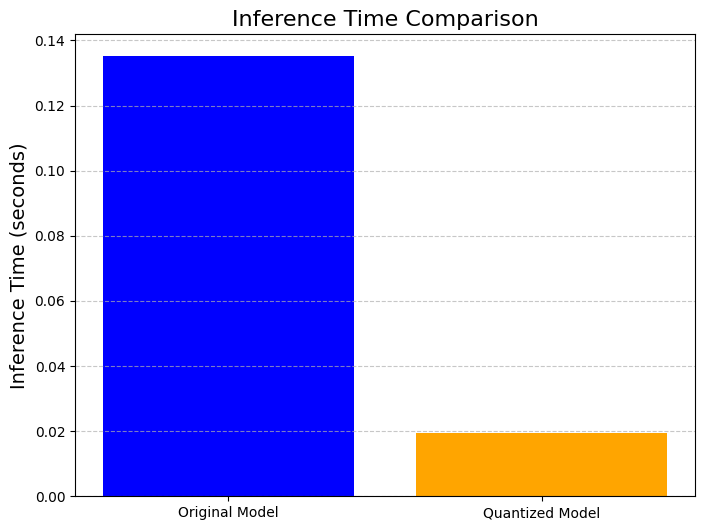

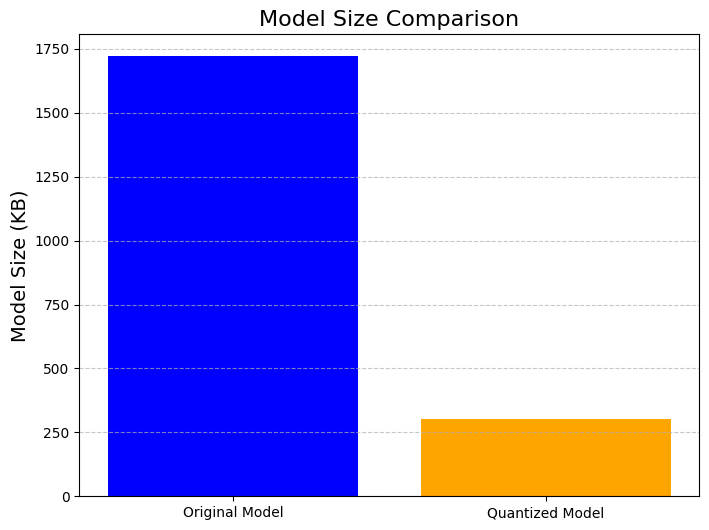

Original Model Inference Time: 0.1351 seconds
Quantized Model Inference Time: 0.0195 seconds
Original Model Size: 1720.89 KB
Quantized Model Size: 303.19 KB


In [ ]:
import time
import os
import matplotlib.pyplot as plt

# Measure inference time for the original model
def measure_inference_time_original(model, test_X):
    start_time = time.time()
    model.predict(test_X)
    end_time = time.time()
    return end_time - start_time

# Measure inference time for the quantized model
def measure_inference_time_quantized(tflite_model_path, test_X):
    # Load the quantized model
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()

    # Get input and output details
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Ensure input data is in the correct format
    test_X = test_X.astype(np.float32)

    # Measure inference time
    start_time = time.time()
    for i in range(test_X.shape[0]):
        input_data = np.expand_dims(test_X[i], axis=0)  # Add batch dimension
        interpreter.set_tensor(input_details[0]['index'], input_data)
        interpreter.invoke()
        _ = interpreter.get_tensor(output_details[0]['index'])
    end_time = time.time()

    return end_time - start_time

# Compare model sizes
def get_model_size(file_path):
    return os.path.getsize(file_path) / 1024  # Size in KB

# Graph for inference time comparison
def plot_inference_time(original_time, quantized_time):
    labels = ['Original Model', 'Quantized Model']
    times = [original_time, quantized_time]

    plt.figure(figsize=(8, 6))
    plt.bar(labels, times, color=['blue', 'orange'])
    plt.ylabel('Inference Time (seconds)', fontsize=14)
    plt.title('Inference Time Comparison', fontsize=16)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Graph for model size comparison
def plot_model_size(original_size, quantized_size):
    labels = ['Original Model', 'Quantized Model']
    sizes = [original_size, quantized_size]

    plt.figure(figsize=(8, 6))
    plt.bar(labels, sizes, color=['blue', 'orange'])
    plt.ylabel('Model Size (KB)', fontsize=14)
    plt.title('Model Size Comparison', fontsize=16)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Integrate the comparisons
original_model_path = "original_model.keras"  # Save the original model to this path
quantized_model_path = os.path.join(quantized_model_folder, "float16_quantized_og_model.tflite")

# Save the original model
model.save(original_model_path)

# Measure inference time
original_time = measure_inference_time_original(model, test_X)
quantized_time = measure_inference_time_quantized(quantized_model_path, test_X)

# Get model sizes
original_size = get_model_size(original_model_path)
quantized_size = get_model_size(quantized_model_path)

# Plot the two separate graphs
plot_inference_time(original_time, quantized_time)
plot_model_size(original_size, quantized_size)

# Print raw values for reference
print(f"Original Model Inference Time: {original_time:.4f} seconds")
print(f"Quantized Model Inference Time: {quantized_time:.4f} seconds")
print(f"Original Model Size: {original_size:.2f} KB")
print(f"Quantized Model Size: {quantized_size:.2f} KB")

In [ ]:
def load_and_predict_tflite_model(tflite_model_path, test_X):
    # Load the quantized model
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()

    # Get input and output details
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Ensure input data is in the correct format
    test_X = test_X.astype(np.float32)  # Use float32 even if the model is quantized to float16

    # Perform inference
    predictions = []
    for i in range(test_X.shape[0]):
        input_data = np.expand_dims(test_X[i], axis=0)  # Add batch dimension
        interpreter.set_tensor(input_details[0]['index'], input_data)
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]['index'])
        predictions.append(output_data[0])

    return np.array(predictions)

In [ ]:
# Generate predictions with the quantized model
quantized_model_predictions = load_and_predict_tflite_model(quantized_model_path, test_X)

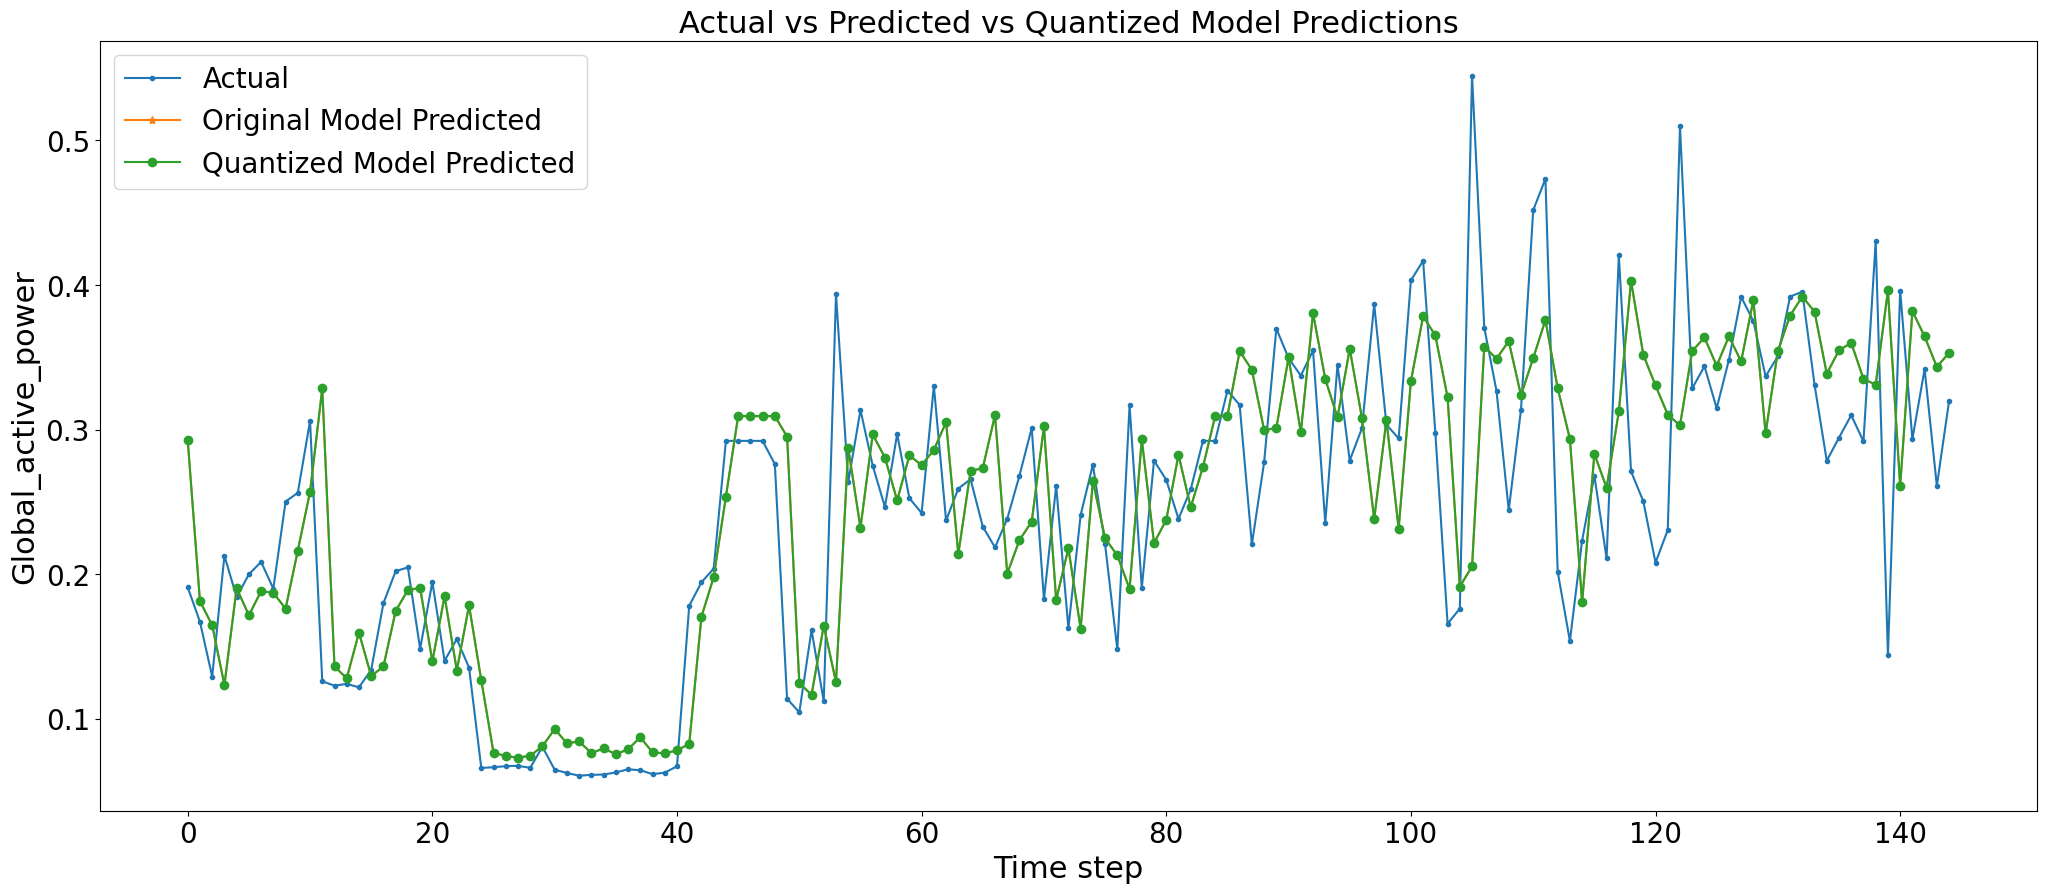

In [ ]:
plt.figure(figsize=(25, 10))
plt.ylabel('Global_active_power', fontsize=22)
plt.xlabel('Time step', fontsize=22)
plt.title("Actual vs Predicted vs Quantized Model Predictions", fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Plot actual values
plt.plot(range(len(test_y)), test_y[:], marker=".", label="Actual")

# Plot original model predictions
plt.plot(range(len(pred_y_test)), pred_y_test[:], marker="*", label="Original Model Predicted")

# Plot quantized model predictions
plt.plot(range(len(quantized_model_predictions)), quantized_model_predictions[:], marker="o", label="Quantized Model Predicted")

# Add legend and show the plot
plt.legend(fontsize=20)
plt.show()

In [ ]:
# Print first few actual values, original predictions, and quantized predictions
print("Actual Values (first 5):", test_y[:5])
print("Original Model Predictions (first 5):", pred_y_test[:5])
print("Quantized Model Predictions (first 5):", quantized_model_predictions[:5])

# Check for differences between original and quantized predictions
diff = pred_y_test - quantized_model_predictions
print("Prediction Differences (first 5):", diff[:5])

# Calculate the absolute differences
diff = np.abs(pred_y_test - quantized_model_predictions)

Actual Values (first 5): [0.19095185 0.16706197 0.12922366 0.21276482 0.18420601]
Original Model Predictions (first 5): [[0.29258662]
 [0.18137519]
 [0.16461864]
 [0.12344517]
 [0.19034913]]
Quantized Model Predictions (first 5): [[0.2926584 ]
 [0.18143204]
 [0.16470686]
 [0.12344898]
 [0.19037074]]
Prediction Differences (first 5): [[-7.1763992e-05]
 [-5.6847930e-05]
 [-8.8214874e-05]
 [-3.8072467e-06]
 [-2.1606684e-05]]


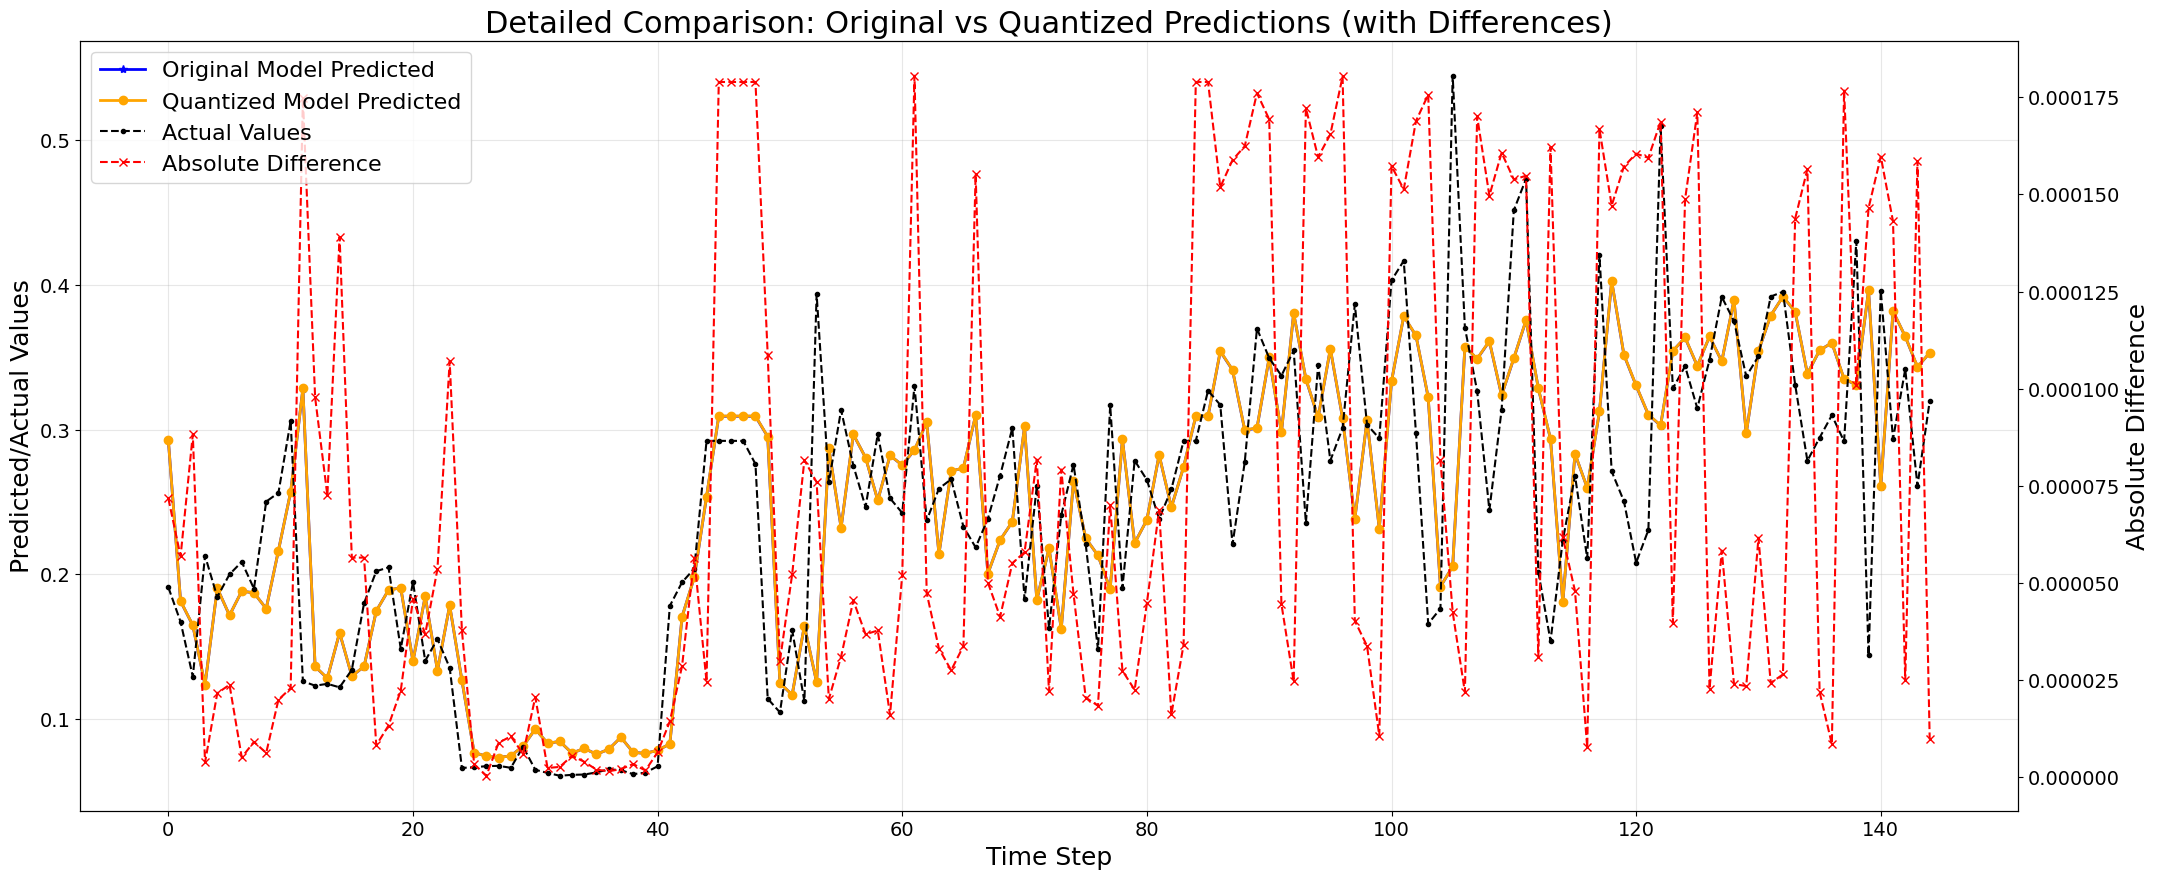

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Create a figure with a secondary y-axis for the differences
fig, ax1 = plt.subplots(figsize=(25, 10))

# Plot the original model predictions
ax1.plot(range(len(pred_y_test)), pred_y_test[:], marker="*", label="Original Model Predicted", color="blue", linewidth=2)

# Plot the quantized model predictions
ax1.plot(range(len(quantized_model_predictions)), quantized_model_predictions[:], marker="o", label="Quantized Model Predicted", color="orange", linewidth=2)

# Plot actual values
ax1.plot(range(len(test_y)), test_y[:], marker=".", label="Actual Values", color="black", linestyle="--", linewidth=1.5)

# Label the primary y-axis
ax1.set_ylabel('Predicted/Actual Values', fontsize=18)
ax1.set_xlabel('Time Step', fontsize=18)

# Add a secondary y-axis for the differences
ax2 = ax1.twinx()
ax2.plot(range(len(diff)), diff, marker="x", label="Absolute Difference", color="red", linestyle="--", linewidth=1.5)
ax2.set_ylabel('Absolute Difference', fontsize=18)

# Add a title and grid
plt.title("Detailed Comparison: Original vs Quantized Predictions (with Differences)", fontsize=22)
ax1.grid(alpha=0.3)

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
plt.legend(lines1 + lines2, labels1 + labels2, fontsize=16, loc="upper left")

# Adjust tick sizes
ax1.tick_params(axis="both", labelsize=14)
ax2.tick_params(axis="y", labelsize=14)

# Show the plot
plt.show()

In [ ]:
# Inspect the quantized model
interpreter = tf.lite.Interpreter(model_path="/content/drive/MyDrive/PES/quantized_models/float16_quantized_og_model.tflite")
interpreter.allocate_tensors()

# Print input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input Details:", input_details)
print("Output Details:", output_details)

Input Details: [{'name': 'serving_default_keras_tensor:0', 'index': 0, 'shape': array([1, 1, 7], dtype=int32), 'shape_signature': array([-1,  1,  7], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output Details: [{'name': 'StatefulPartitionedCall_1:0', 'index': 353, 'shape': array([1, 1], dtype=int32), 'shape_signature': array([-1,  1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [ ]:
# Optional: Compare performance metrics
original_mse = tf.keras.losses.MeanSquaredError()(test_y, pred_y_test).numpy()
quantized_mse = tf.keras.losses.MeanSquaredError()(test_y, quantized_model_predictions).numpy()
print(f"Original Model MSE: {original_mse:.4f}")
print(f"Quantized Model MSE: {quantized_mse:.4f}")

Original Model MSE: 0.0058
Quantized Model MSE: 0.0058


Overall MAE (Original Model): 0.05360420047209703
Overall MAE (Quantized Model): 0.05363199848553753


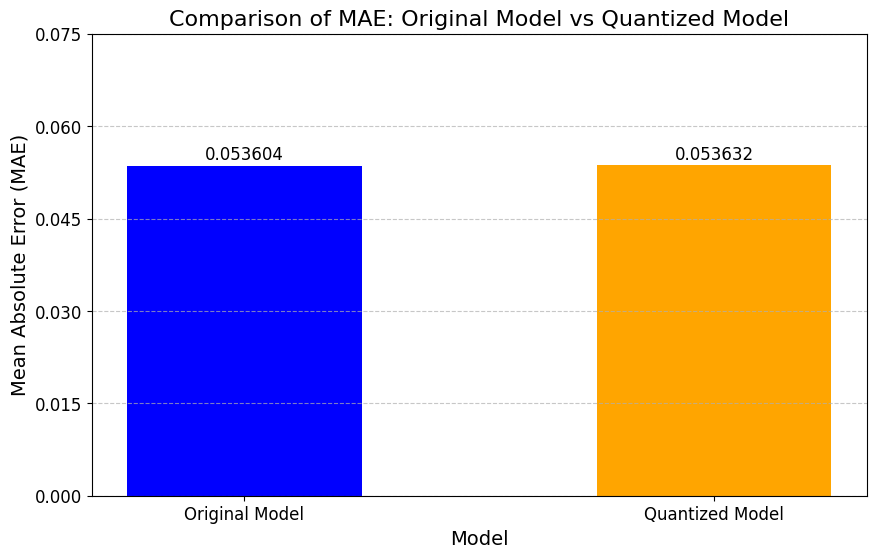

In [ ]:
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

# Calculate overall MAE for both models
overall_mae_original = mean_absolute_error(test_y, pred_y_test)
overall_mae_quantized = mean_absolute_error(test_y, quantized_model_predictions)

# Print the overall MAE values
print(f"Overall MAE (Original Model): {overall_mae_original}")
print(f"Overall MAE (Quantized Model): {overall_mae_quantized}")

# Data for the bar graph
models = ['Original Model', 'Quantized Model']
mae_values = [overall_mae_original, overall_mae_quantized]

# Create the bar graph
plt.figure(figsize=(10, 6))
bars = plt.bar(models, mae_values, color=['blue', 'orange'], width=0.5)

# Define y-axis tick increments of 0.015
min_tick = 0  # Start at 0 or slightly below the lowest MAE
max_tick = max(mae_values) + 0.015  # Slightly above the maximum MAE
yticks = np.arange(min_tick, max_tick + 0.015, 0.015)  # Create ticks spaced by 0.015
plt.yticks(yticks)

# Add labels and title
plt.ylabel('Mean Absolute Error (MAE)', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.title('Comparison of MAE: Original Model vs Quantized Model', fontsize=16)

# Add gridlines for better precision
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add MAE values on top of the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 0.001, f"{height:.6f}", ha='center', fontsize=12)

# Show the plot
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Original Model MAE: 0.053604200472097
Quantized Model MAE: 0.053631998485538
Original Model RMSE: 0.076397927243854
Quantized Model RMSE: 0.076417317574406
Original Model MSE: 0.005836643287157
Quantized Model MSE: 0.005839606425268


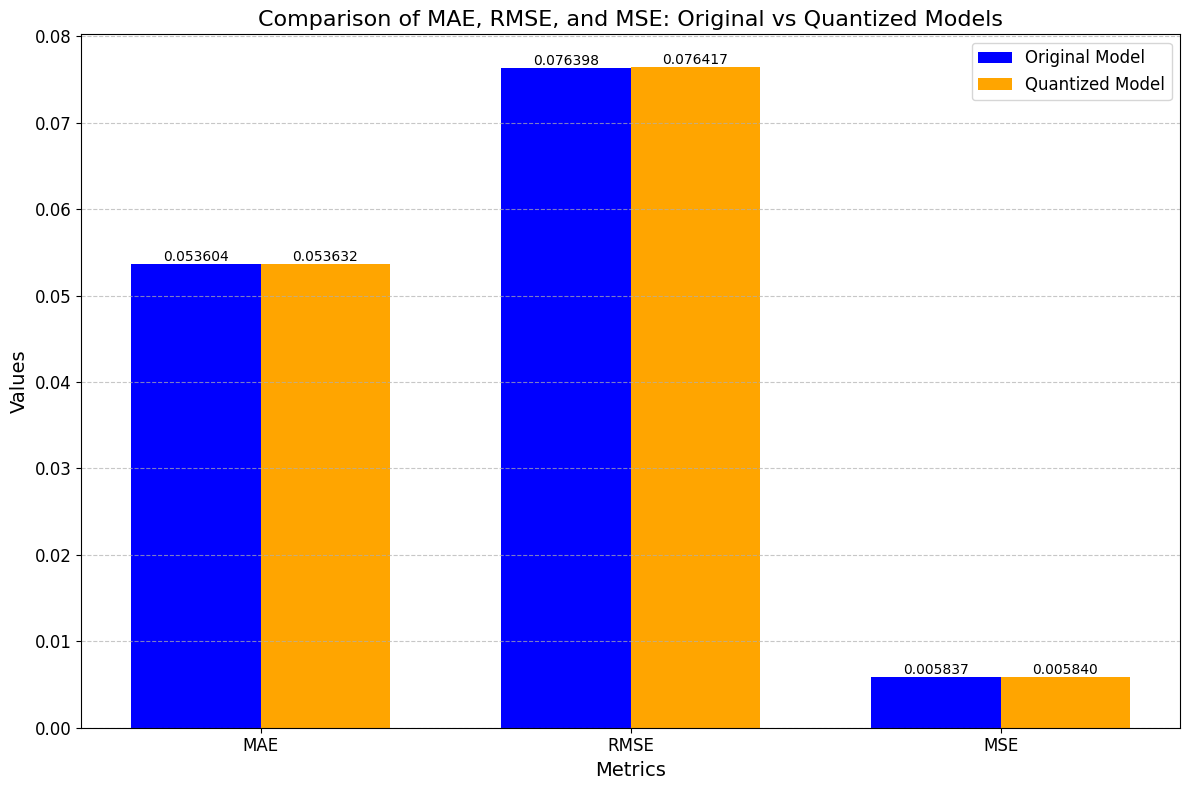

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate performance metrics
original_mae = mean_absolute_error(test_y, pred_y_test)
quantized_mae = mean_absolute_error(test_y, quantized_model_predictions)

original_mse = mean_squared_error(test_y, pred_y_test)
quantized_mse = mean_squared_error(test_y, quantized_model_predictions)

# Calculate RMSE
original_rmse = np.sqrt(original_mse)
quantized_rmse = np.sqrt(quantized_mse)

# Print full-precision metrics to the console
print(f"Original Model MAE: {original_mae:.15f}")
print(f"Quantized Model MAE: {quantized_mae:.15f}")
print(f"Original Model RMSE: {original_rmse:.15f}")
print(f"Quantized Model RMSE: {quantized_rmse:.15f}")
print(f"Original Model MSE: {original_mse:.15f}")
print(f"Quantized Model MSE: {quantized_mse:.15f}")

# Data for the bar chart
metrics = ['MAE', 'RMSE', 'MSE']
original_values = [original_mae, original_rmse, original_mse]
quantized_values = [quantized_mae, quantized_rmse, quantized_mse]

# Define the bar width and positions
bar_width = 0.35
x = np.arange(len(metrics))  # the label locations

# Create the bar chart
plt.figure(figsize=(12, 8))
bar1 = plt.bar(x - bar_width/2, original_values, bar_width, label='Original Model', color='blue')
bar2 = plt.bar(x + bar_width/2, quantized_values, bar_width, label='Quantized Model', color='orange')

# Add labels, title, and legend
plt.xlabel('Metrics', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.title('Comparison of MAE, RMSE, and MSE: Original vs Quantized Models', fontsize=16)
plt.xticks(x, metrics, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

# Display values (with 6 decimal places) on top of the bars
for bars, values in zip([bar1, bar2], [original_values, quantized_values]):
    for bar, value in zip(bars, values):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, height, f'{value:.6f}', ha='center', va='bottom', fontsize=10)

# Add gridlines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

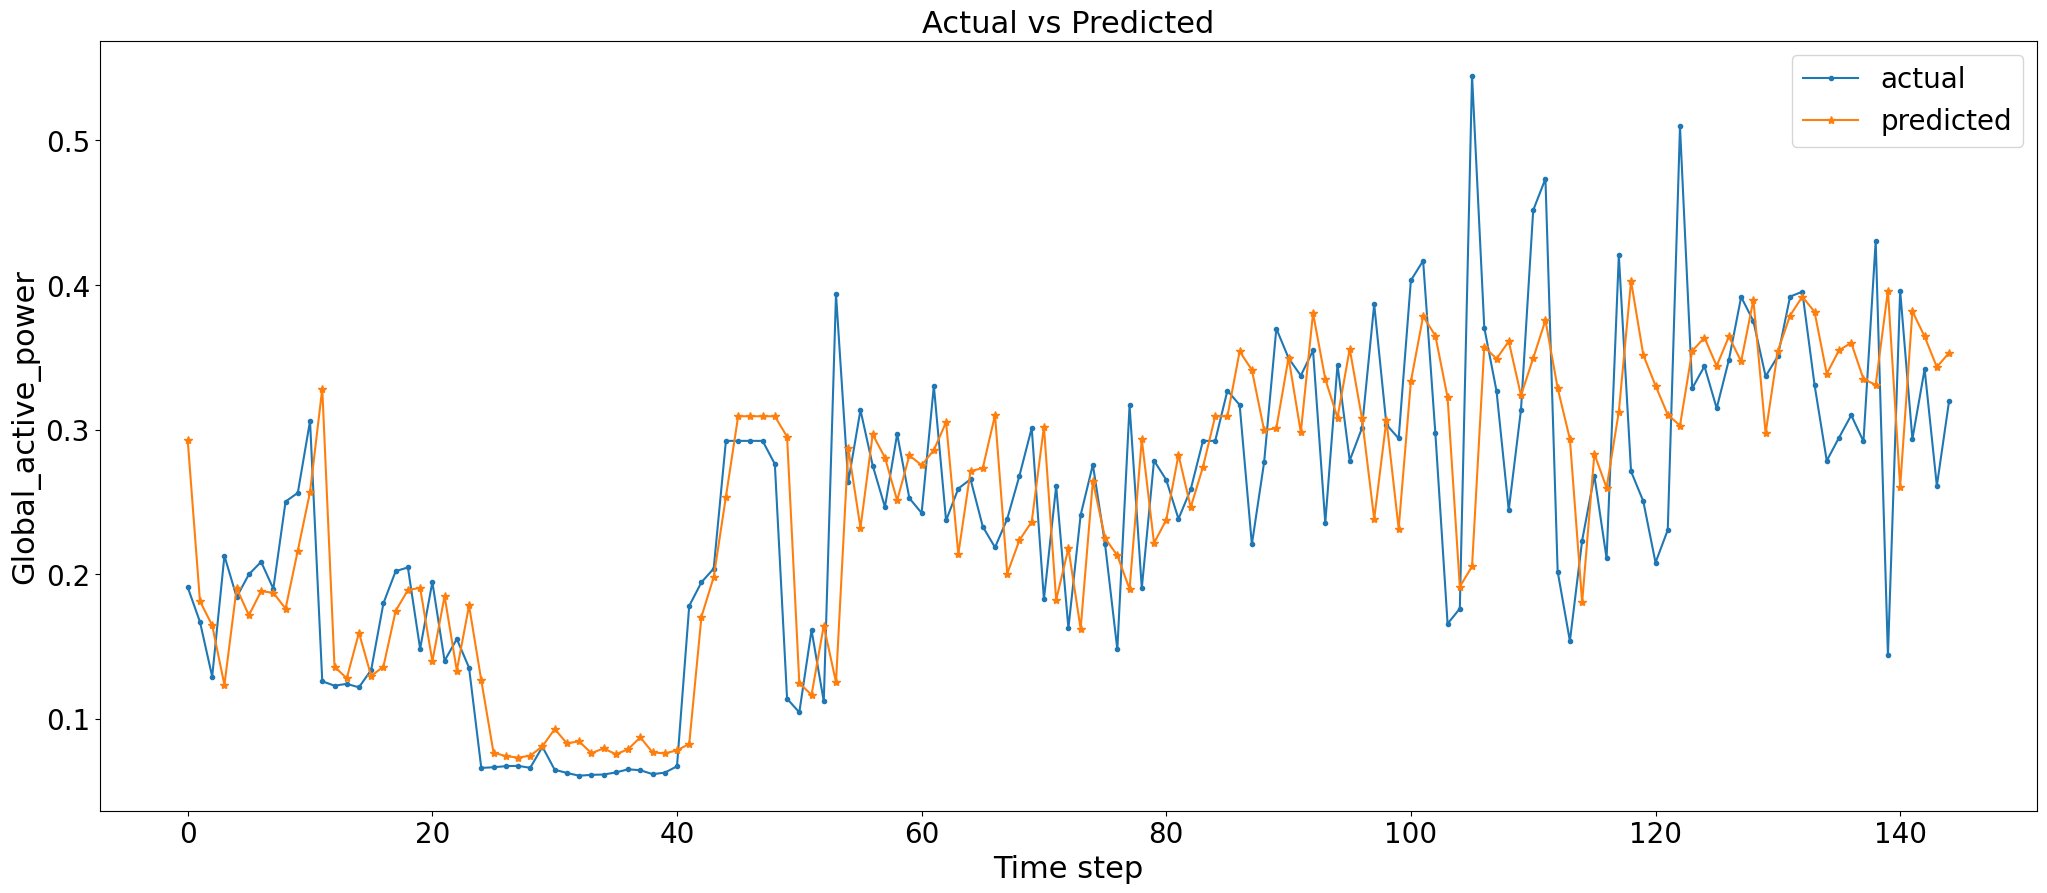

In [ ]:
plt.figure(figsize=(25, 10))
plt.ylabel('Global_active_power', fontsize=22)
plt.xlabel('Time step', fontsize=22)
plt.title("Actual vs Predicted", fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(range(len(test_y)), test_y[:], marker=".", label="actual")
plt.plot(range(len(pred_y_test)), pred_y_test[:], marker="*", label="predicted")
plt.legend(fontsize=20)
plt.show()

fgsm attack

In [ ]:
def fgsm_attack(model, epsilon, data, label):
  data = tf.convert_to_tensor(data)
  with tf.GradientTape() as tape:
    tape.watch(data)
    predictions = model(data)
    # print("Predictions", predictions)
    loss = tf.keras.losses.MSE(label, predictions)
  gradient = tape.gradient(loss, data)
  # print(gradient.shape)
  advX = data + (epsilon * np.sign(gradient))
  return advX

In [ ]:
advX = fgsm_attack(model, 0.05, test_X, test_y)
attack_loss = model.evaluate(advX, test_y)
print(f"Attack Loss: {attack_loss[0]:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis 3 of a tensor of shape (145, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0171 - mae: 0.1145
Attack Loss: 0.0189


In [ ]:
test_pred_advy = model.predict(advX)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


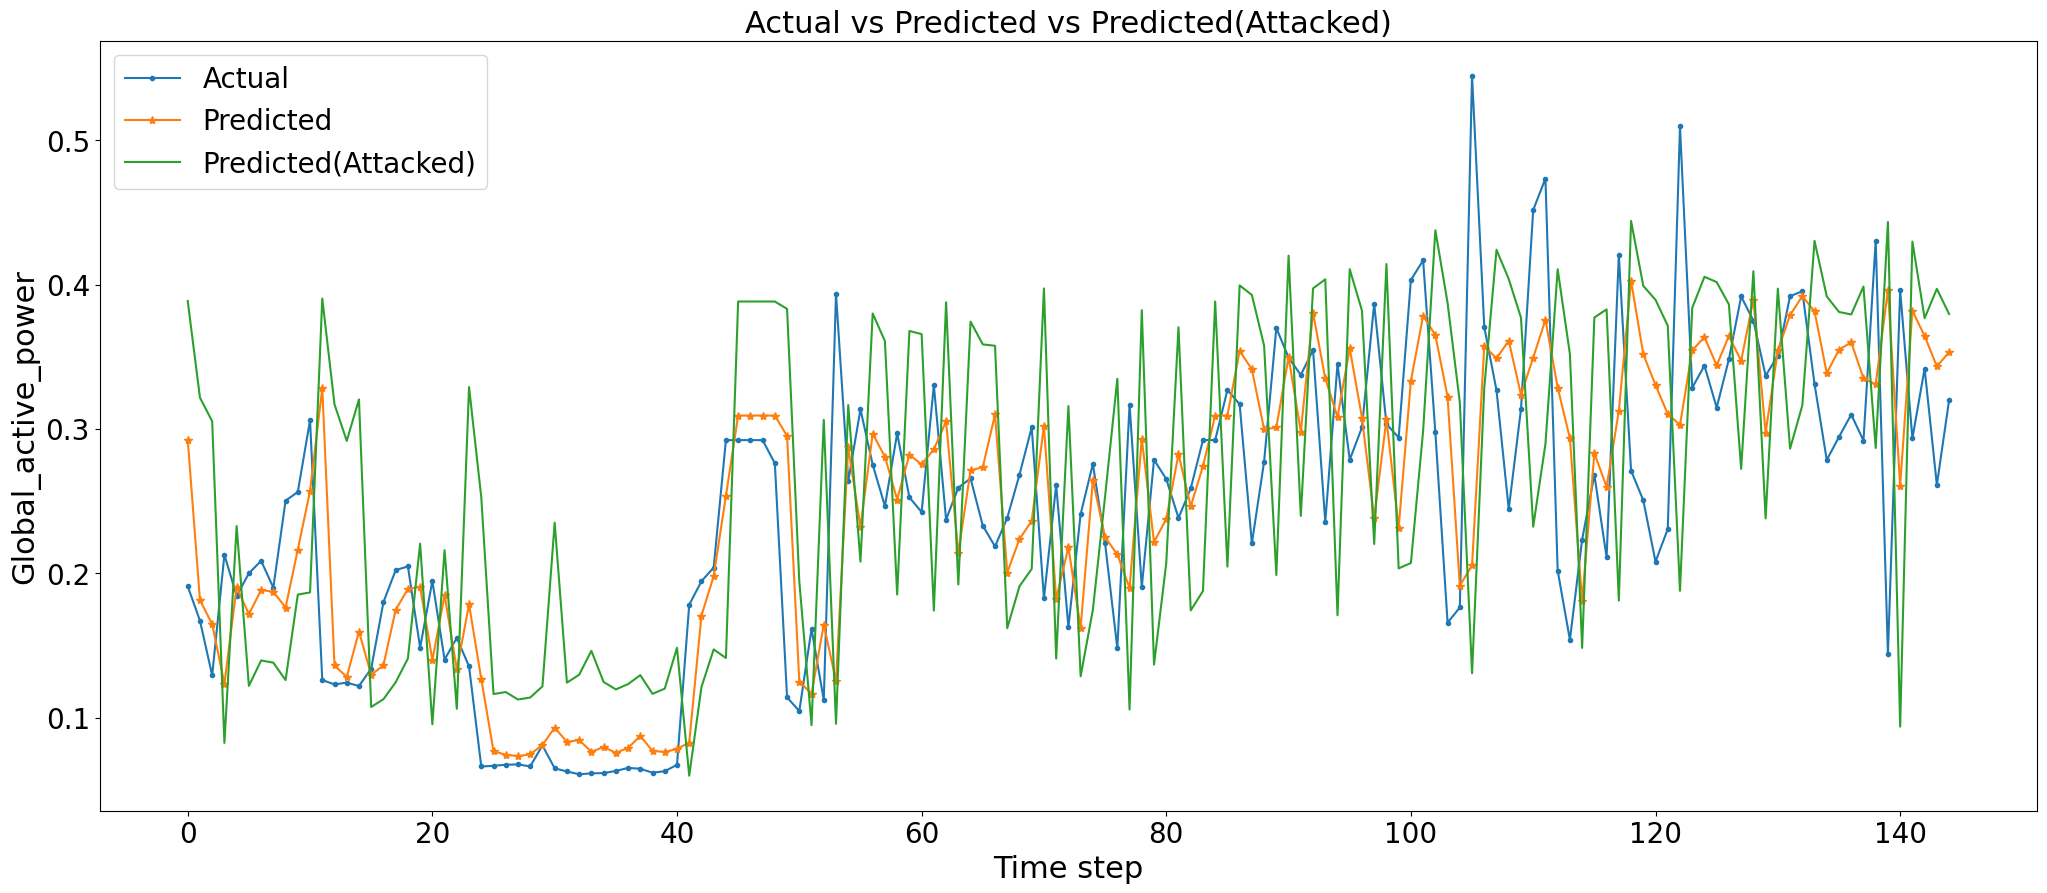

In [ ]:
plt.figure(figsize=(25, 10))
plt.ylabel('Global_active_power', fontsize=22)
plt.xlabel('Time step', fontsize=22)
plt.title("Actual vs Predicted vs Predicted(Attacked)", fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(range(len(test_y)), test_y[:], marker=".", label="Actual")
plt.plot(range(len(pred_y_test)), pred_y_test[:], marker="*", label="Predicted")
plt.plot(range(len(test_pred_advy)), test_pred_advy[:], label="Predicted(Attacked)")
plt.legend(fontsize=20)
plt.show()

adversarial defense training

In [ ]:
def adversarial_train(model, X_train, y_train, X_val, y_val, epsilon, epochs=50, batch_size=32):
  for epoch in range(epochs):
    advX_train = fgsm_attack(model, epsilon, X_train, y_train)

    combined_X = tf.concat([X_train, advX_train], axis=0)
    combined_y = tf.concat([y_train, y_train], axis=0)

    history = model.fit(
        combined_X, combined_y,
        validation_data=(X_val, y_val),
        epochs=1,
        batch_size=batch_size,
        verbose=0
    )

    if epoch % 10 == 0:
      print(f'Epoch {epoch}/{epochs}, Loss: {history.history["loss"][0]:.4f}, Val Loss: {history.history["val_loss"][0]:.4f}')

  return model

In [ ]:
robust_model = adversarial_train(model, train_X, train_y, val_X, val_y, epsilon=0.05)

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1036, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Epoch 0/50, Loss: 0.0156, Val Loss: 0.0071
Epoch 10/50, Loss: 0.0152, Val Loss: 0.0070
Epoch 20/50, Loss: 0.0149, Val Loss: 0.0070
Epoch 30/50, Loss: 0.0150, Val Loss: 0.0076
Epoch 40/50, Loss: 0.0149, Val Loss: 0.0068


In [ ]:
robust_test_loss = robust_model.evaluate(test_X, test_y)
print(f"Robust Model Test Loss: {robust_test_loss[0]:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0057 - mae: 0.0600
Robust Model Test Loss: 0.0062


In [ ]:
robust_attack_loss = robust_model.evaluate(advX, test_y)
print(f"Robust Model Attack Loss: {robust_attack_loss[0]:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0106 - mae: 0.0874
Robust Model Attack Loss: 0.0110


In [ ]:
robust_pred_y_test = robust_model.predict(test_X)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [ ]:
robust_test_pred_advy = robust_model.predict(advX)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [ ]:
# Quantize the FGSM-robust model
fgsm_robust_quantized_path = convert_to_tflite(
    robust_model,  # FGSM-robust model after adversarial training
    quantized_model_folder,
    model_name="float16_quantized_fgsm_robust_model.tflite"
)

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Saved artifact at '/tmp/tmpklssccqz'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 1, 7), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  138159593180048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138159593181200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138159593178320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138159593177936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138159593181584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138159593181008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138159593182160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138159593182544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138159593183312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138159593181392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138159593184272: Tens

In [ ]:
# Save the FGSM-robust model to a separate folder for unquantized models
unquantized_model_folder = "/content/drive/MyDrive/PES/unquantized_models"
os.makedirs(unquantized_model_folder, exist_ok=True)  # Ensure the folder exists

# Save the unquantized FGSM-robust model
fgsm_robust_model_path = os.path.join(unquantized_model_folder, "fgsm_robust_model.keras")
robust_model.save(fgsm_robust_model_path)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


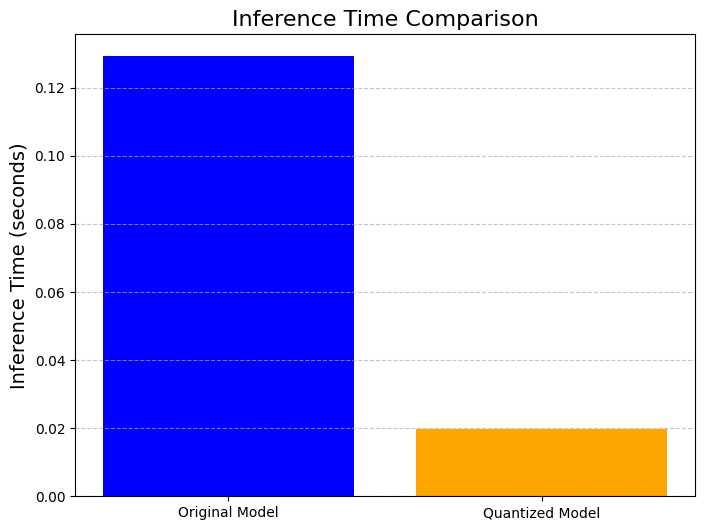

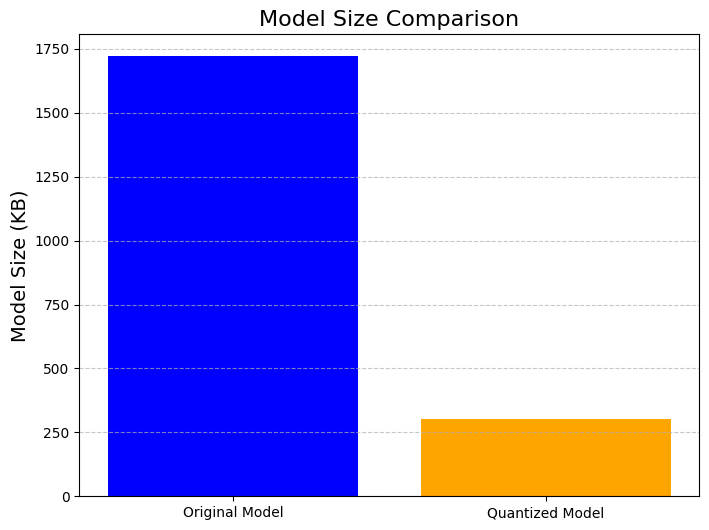

FGSM-Robust Model Inference Time (Original): 0.1293 seconds
FGSM-Robust Model Inference Time (Quantized): 0.0199 seconds
FGSM-Robust Model Size (Original): 1720.89 KB
FGSM-Robust Model Size (Quantized): 303.19 KB


In [ ]:
# Measure inference time for FGSM-robust model on clean test data
fgsm_robust_time_original = measure_inference_time_original(robust_model, test_X)
fgsm_robust_time_quantized = measure_inference_time_quantized(fgsm_robust_quantized_path, test_X)

# Get model sizes
fgsm_robust_original_size = get_model_size(fgsm_robust_model_path)
fgsm_robust_quantized_size = get_model_size(fgsm_robust_quantized_path)

# Plot inference time comparison for FGSM-robust model
plot_inference_time(fgsm_robust_time_original, fgsm_robust_time_quantized)

# Plot model size comparison for FGSM-robust model
plot_model_size(fgsm_robust_original_size, fgsm_robust_quantized_size)

# Print results for FGSM-robust model
print(f"FGSM-Robust Model Inference Time (Original): {fgsm_robust_time_original:.4f} seconds")
print(f"FGSM-Robust Model Inference Time (Quantized): {fgsm_robust_time_quantized:.4f} seconds")
print(f"FGSM-Robust Model Size (Original): {fgsm_robust_original_size:.2f} KB")
print(f"FGSM-Robust Model Size (Quantized): {fgsm_robust_quantized_size:.2f} KB")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


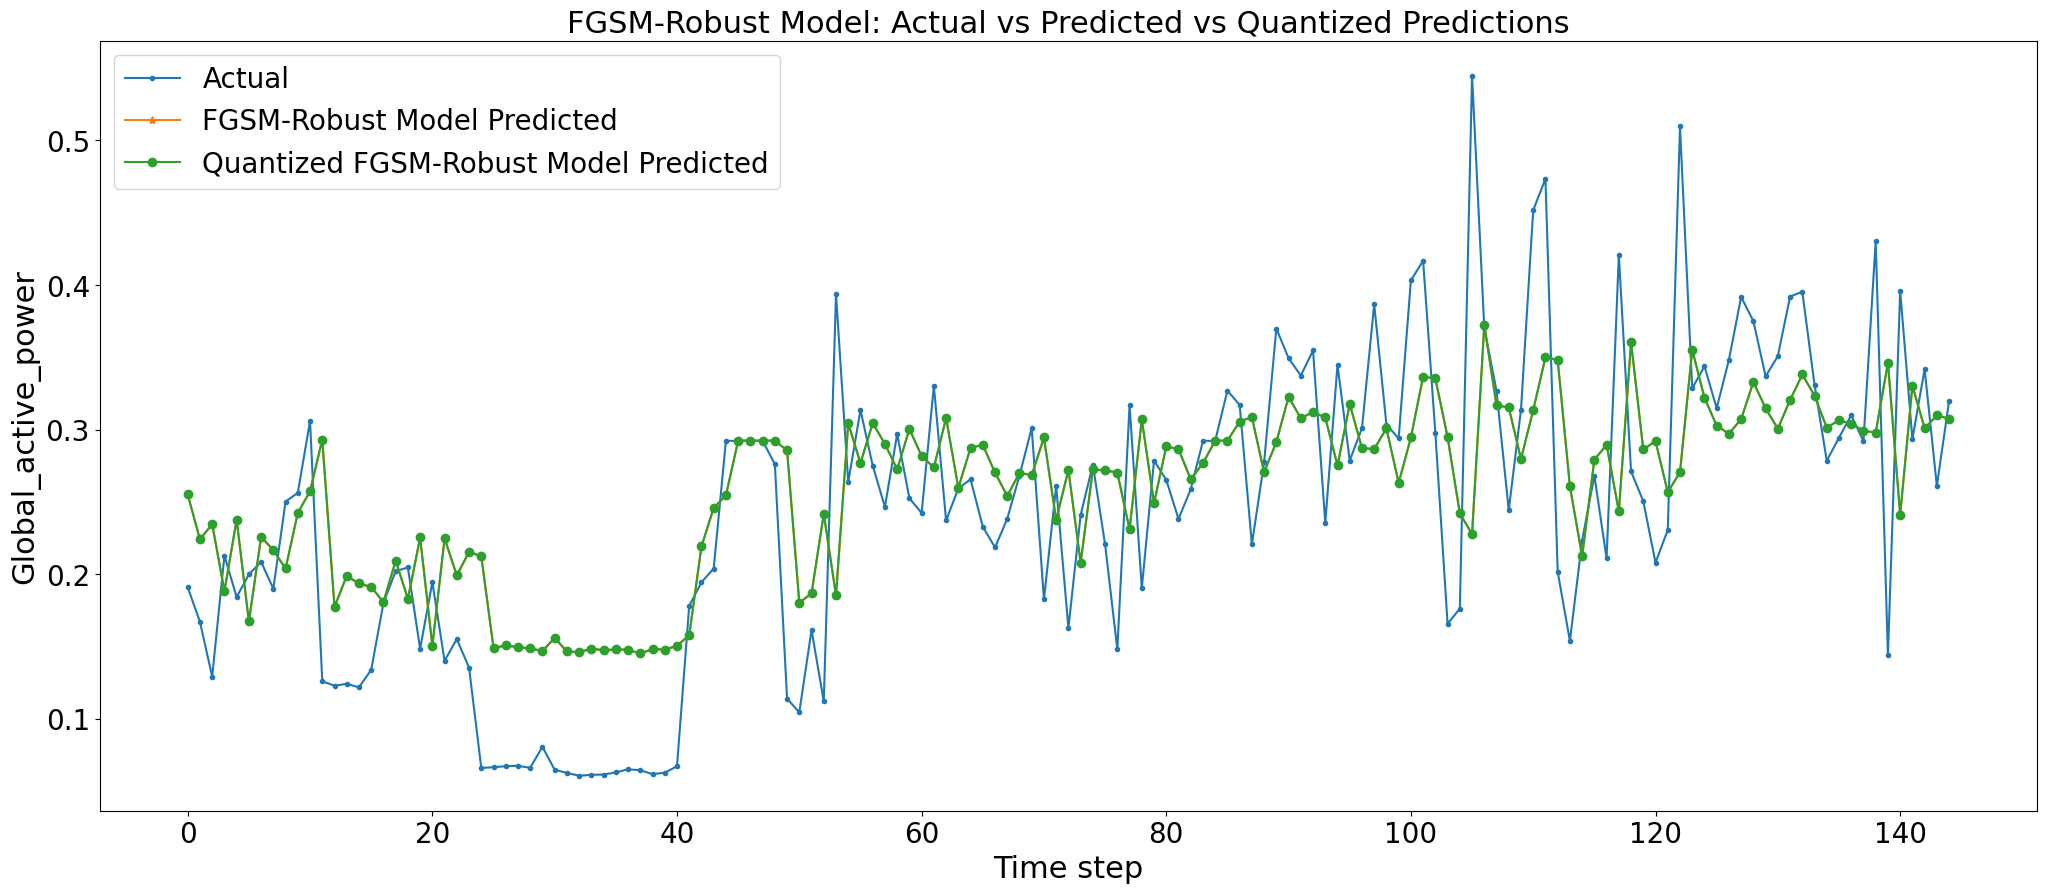

Actual Values (first 5): [0.19095185 0.16706197 0.12922366 0.21276482 0.18420601]
FGSM-Robust Model Predictions (first 5): [[0.25492778]
 [0.22384122]
 [0.23451462]
 [0.1881046 ]
 [0.23753347]]
Quantized FGSM-Robust Model Predictions (first 5): [[0.25514567]
 [0.22415933]
 [0.23474523]
 [0.18848254]
 [0.23774232]]
FGSM-Robust Prediction Differences (first 5): [[-0.00021788]
 [-0.00031811]
 [-0.00023061]
 [-0.00037794]
 [-0.00020885]]


In [ ]:
# Generate predictions with the quantized FGSM-robust model
quantized_fgsm_robust_predictions = load_and_predict_tflite_model(fgsm_robust_quantized_path, test_X)

# Plot predictions for FGSM-robust model (original vs quantized)
plt.figure(figsize=(25, 10))
plt.ylabel('Global_active_power', fontsize=22)
plt.xlabel('Time step', fontsize=22)
plt.title("FGSM-Robust Model: Actual vs Predicted vs Quantized Predictions", fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Plot actual values
plt.plot(range(len(test_y)), test_y[:], marker=".", label="Actual")

# Plot FGSM-robust model predictions
fgsm_robust_pred_y_test = robust_model.predict(test_X)
plt.plot(range(len(fgsm_robust_pred_y_test)), fgsm_robust_pred_y_test[:], marker="*", label="FGSM-Robust Model Predicted")

# Plot quantized FGSM-robust model predictions
plt.plot(range(len(quantized_fgsm_robust_predictions)), quantized_fgsm_robust_predictions[:], marker="o", label="Quantized FGSM-Robust Model Predicted")

# Add legend and show the plot
plt.legend(fontsize=20)
plt.show()

# Print first few actual values, FGSM-robust predictions, and quantized FGSM-robust predictions
print("Actual Values (first 5):", test_y[:5])
print("FGSM-Robust Model Predictions (first 5):", fgsm_robust_pred_y_test[:5])
print("Quantized FGSM-Robust Model Predictions (first 5):", quantized_fgsm_robust_predictions[:5])

# Check for differences between FGSM-robust and quantized FGSM-robust predictions
fgsm_robust_diff = fgsm_robust_pred_y_test - quantized_fgsm_robust_predictions
print("FGSM-Robust Prediction Differences (first 5):", fgsm_robust_diff[:5])

# Calculate the absolute differences
fgsm_robust_diff_abs = np.abs(fgsm_robust_pred_y_test - quantized_fgsm_robust_predictions)

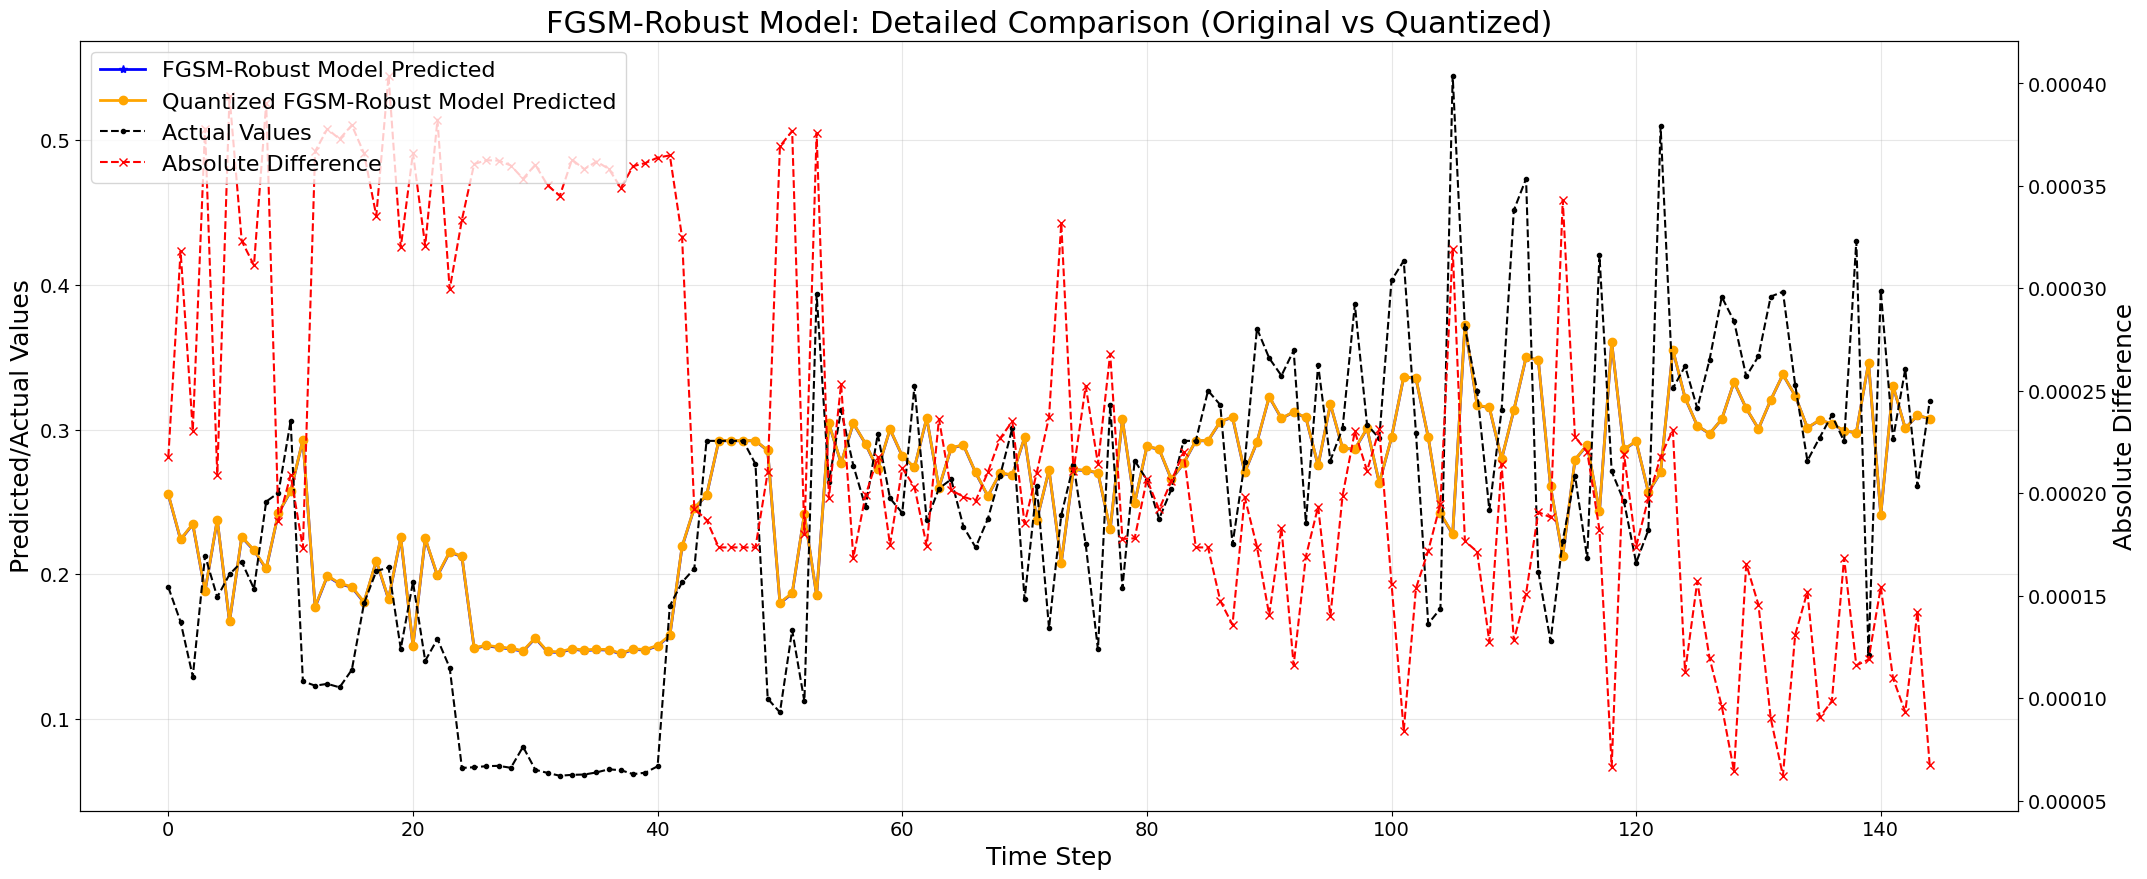

In [ ]:
# Create a figure with a secondary y-axis for the differences
fig, ax1 = plt.subplots(figsize=(25, 10))

# Plot the FGSM-robust model predictions
ax1.plot(range(len(fgsm_robust_pred_y_test)), fgsm_robust_pred_y_test[:], marker="*", label="FGSM-Robust Model Predicted", color="blue", linewidth=2)

# Plot the quantized FGSM-robust model predictions
ax1.plot(range(len(quantized_fgsm_robust_predictions)), quantized_fgsm_robust_predictions[:], marker="o", label="Quantized FGSM-Robust Model Predicted", color="orange", linewidth=2)

# Plot actual values
ax1.plot(range(len(test_y)), test_y[:], marker=".", label="Actual Values", color="black", linestyle="--", linewidth=1.5)

# Label the primary y-axis
ax1.set_ylabel('Predicted/Actual Values', fontsize=18)
ax1.set_xlabel('Time Step', fontsize=18)

# Add a secondary y-axis for the differences
ax2 = ax1.twinx()
ax2.plot(range(len(fgsm_robust_diff_abs)), fgsm_robust_diff_abs, marker="x", label="Absolute Difference", color="red", linestyle="--", linewidth=1.5)
ax2.set_ylabel('Absolute Difference', fontsize=18)

# Add a title and grid
plt.title("FGSM-Robust Model: Detailed Comparison (Original vs Quantized)", fontsize=22)
ax1.grid(alpha=0.3)

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
plt.legend(lines1 + lines2, labels1 + labels2, fontsize=16, loc="upper left")

# Adjust tick sizes
ax1.tick_params(axis="both", labelsize=14)
ax2.tick_params(axis="y", labelsize=14)

# Show the plot
plt.show()

In [ ]:
# Inspect the quantized FGSM-robust model
interpreter = tf.lite.Interpreter(model_path=fgsm_robust_quantized_path)
interpreter.allocate_tensors()

# Print input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input Details [FGSM-Robust]:", input_details)
print("Output Details [FGSM-Robust]:", output_details)

Input Details [FGSM-Robust]: [{'name': 'serving_default_keras_tensor:0', 'index': 0, 'shape': array([1, 1, 7], dtype=int32), 'shape_signature': array([-1,  1,  7], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output Details [FGSM-Robust]: [{'name': 'StatefulPartitionedCall_1:0', 'index': 353, 'shape': array([1, 1], dtype=int32), 'shape_signature': array([-1,  1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [ ]:
# Compare performance metrics for FGSM-robust model
fgsm_robust_mse_original = tf.keras.losses.MeanSquaredError()(test_y, fgsm_robust_pred_y_test).numpy()
fgsm_robust_mse_quantized = tf.keras.losses.MeanSquaredError()(test_y, quantized_fgsm_robust_predictions).numpy()
print(f"FGSM-Robust Model MSE (Original): {fgsm_robust_mse_original:.4f}")
print(f"FGSM-Robust Model MSE (Quantized): {fgsm_robust_mse_quantized:.4f}")

FGSM-Robust Model MSE (Original): 0.0062
FGSM-Robust Model MSE (Quantized): 0.0063


FGSM-Robust Model MAE (Original): 0.060296380800937265
FGSM-Robust Model MAE (Quantized): 0.060367424810244597


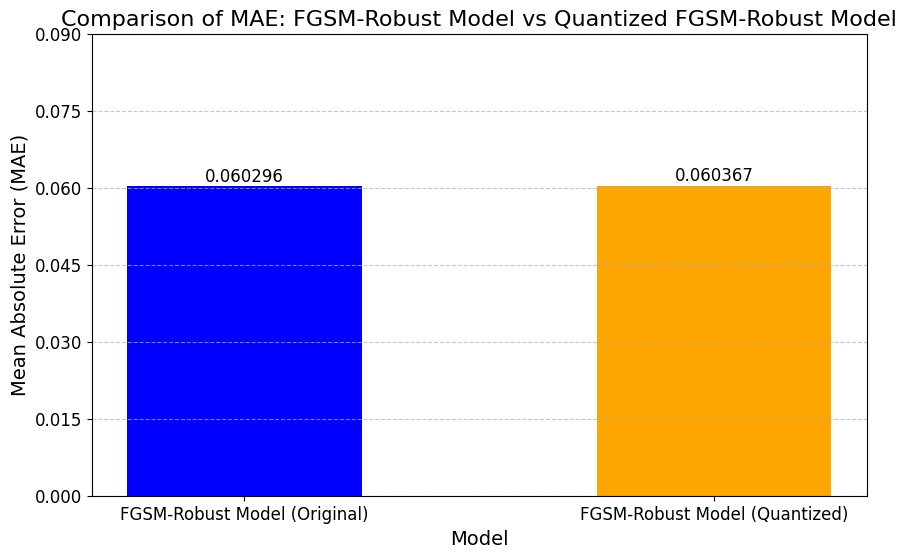

In [ ]:
from sklearn.metrics import mean_absolute_error

# Calculate overall MAE for FGSM-robust model
fgsm_robust_mae_original = mean_absolute_error(test_y, fgsm_robust_pred_y_test)
fgsm_robust_mae_quantized = mean_absolute_error(test_y, quantized_fgsm_robust_predictions)

# Print the overall MAE values
print(f"FGSM-Robust Model MAE (Original): {fgsm_robust_mae_original}")
print(f"FGSM-Robust Model MAE (Quantized): {fgsm_robust_mae_quantized}")

# Data for the bar graph
models = ['FGSM-Robust Model (Original)', 'FGSM-Robust Model (Quantized)']
mae_values = [fgsm_robust_mae_original, fgsm_robust_mae_quantized]

# Create the bar graph for MAE
plt.figure(figsize=(10, 6))
bars = plt.bar(models, mae_values, color=['blue', 'orange'], width=0.5)

# Define y-axis tick increments of 0.015
min_tick = 0  # Start at 0 or slightly below the lowest MAE
max_tick = max(mae_values) + 0.015  # Slightly above the maximum MAE
yticks = np.arange(min_tick, max_tick + 0.015, 0.015)  # Create ticks spaced by 0.015
plt.yticks(yticks)

# Add labels and title
plt.ylabel('Mean Absolute Error (MAE)', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.title('Comparison of MAE: FGSM-Robust Model vs Quantized FGSM-Robust Model', fontsize=16)

# Add gridlines for better precision
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add MAE values on top of the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 0.001, f"{height:.6f}", ha='center', fontsize=12)

# Show the plot
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

we can use this graph instead of having separate graphs for MAE, MSE, RMSE

FGSM-Robust Model MAE (Original): 0.060296380801
FGSM-Robust Model MAE (Quantized): 0.060367424810
FGSM-Robust Model RMSE (Original): 0.079047875710
FGSM-Robust Model RMSE (Quantized): 0.079108237790
FGSM-Robust Model MSE (Original): 0.006248566654
FGSM-Robust Model MSE (Quantized): 0.006258113286


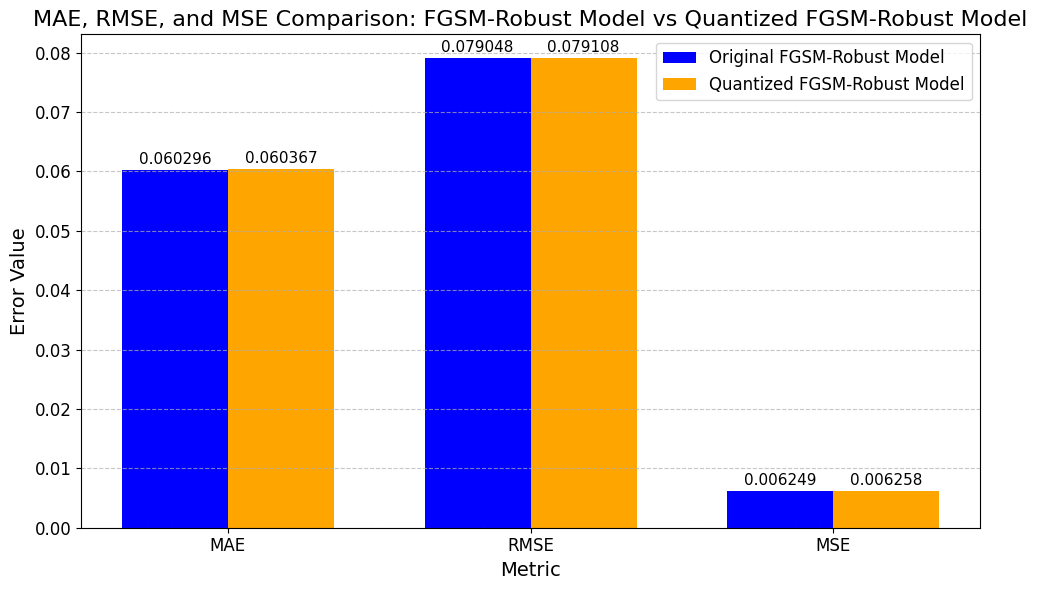

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Calculate MAE, RMSE, and MSE for FGSM-robust model
fgsm_robust_mae_original = mean_absolute_error(test_y, fgsm_robust_pred_y_test)
fgsm_robust_mae_quantized = mean_absolute_error(test_y, quantized_fgsm_robust_predictions)

fgsm_robust_rmse_original = np.sqrt(mean_squared_error(test_y, fgsm_robust_pred_y_test))
fgsm_robust_rmse_quantized = np.sqrt(mean_squared_error(test_y, quantized_fgsm_robust_predictions))

fgsm_robust_mse_original = mean_squared_error(test_y, fgsm_robust_pred_y_test)
fgsm_robust_mse_quantized = mean_squared_error(test_y, quantized_fgsm_robust_predictions)

# Print the MAE, RMSE, and MSE values with high precision for the console (10+ decimal places)
print(f"FGSM-Robust Model MAE (Original): {fgsm_robust_mae_original:.12f}")
print(f"FGSM-Robust Model MAE (Quantized): {fgsm_robust_mae_quantized:.12f}")
print(f"FGSM-Robust Model RMSE (Original): {fgsm_robust_rmse_original:.12f}")
print(f"FGSM-Robust Model RMSE (Quantized): {fgsm_robust_rmse_quantized:.12f}")
print(f"FGSM-Robust Model MSE (Original): {fgsm_robust_mse_original:.12f}")
print(f"FGSM-Robust Model MSE (Quantized): {fgsm_robust_mse_quantized:.12f}")

# Data for the bar graph
metrics = ['MAE', 'RMSE', 'MSE']
original_values = [fgsm_robust_mae_original, fgsm_robust_rmse_original, fgsm_robust_mse_original]
quantized_values = [fgsm_robust_mae_quantized, fgsm_robust_rmse_quantized, fgsm_robust_mse_quantized]

# Create a grouped bar graph for MAE, RMSE, and MSE
x = np.arange(len(metrics))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, original_values, width, label='Original FGSM-Robust Model', color='blue')
bars2 = ax.bar(x + width/2, quantized_values, width, label='Quantized FGSM-Robust Model', color='orange')

# Add labels and title
ax.set_ylabel('Error Value', fontsize=14)
ax.set_xlabel('Metric', fontsize=14)
ax.set_title('MAE, RMSE, and MSE Comparison: FGSM-Robust Model vs Quantized FGSM-Robust Model', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=12)
ax.legend(fontsize=12)

# Add gridlines for better visualization
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Add values on top of the bars (6 decimal places for precision)
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2.0, height + 0.001, f"{height:.6f}", ha='center', fontsize=11)

# Show the plot
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

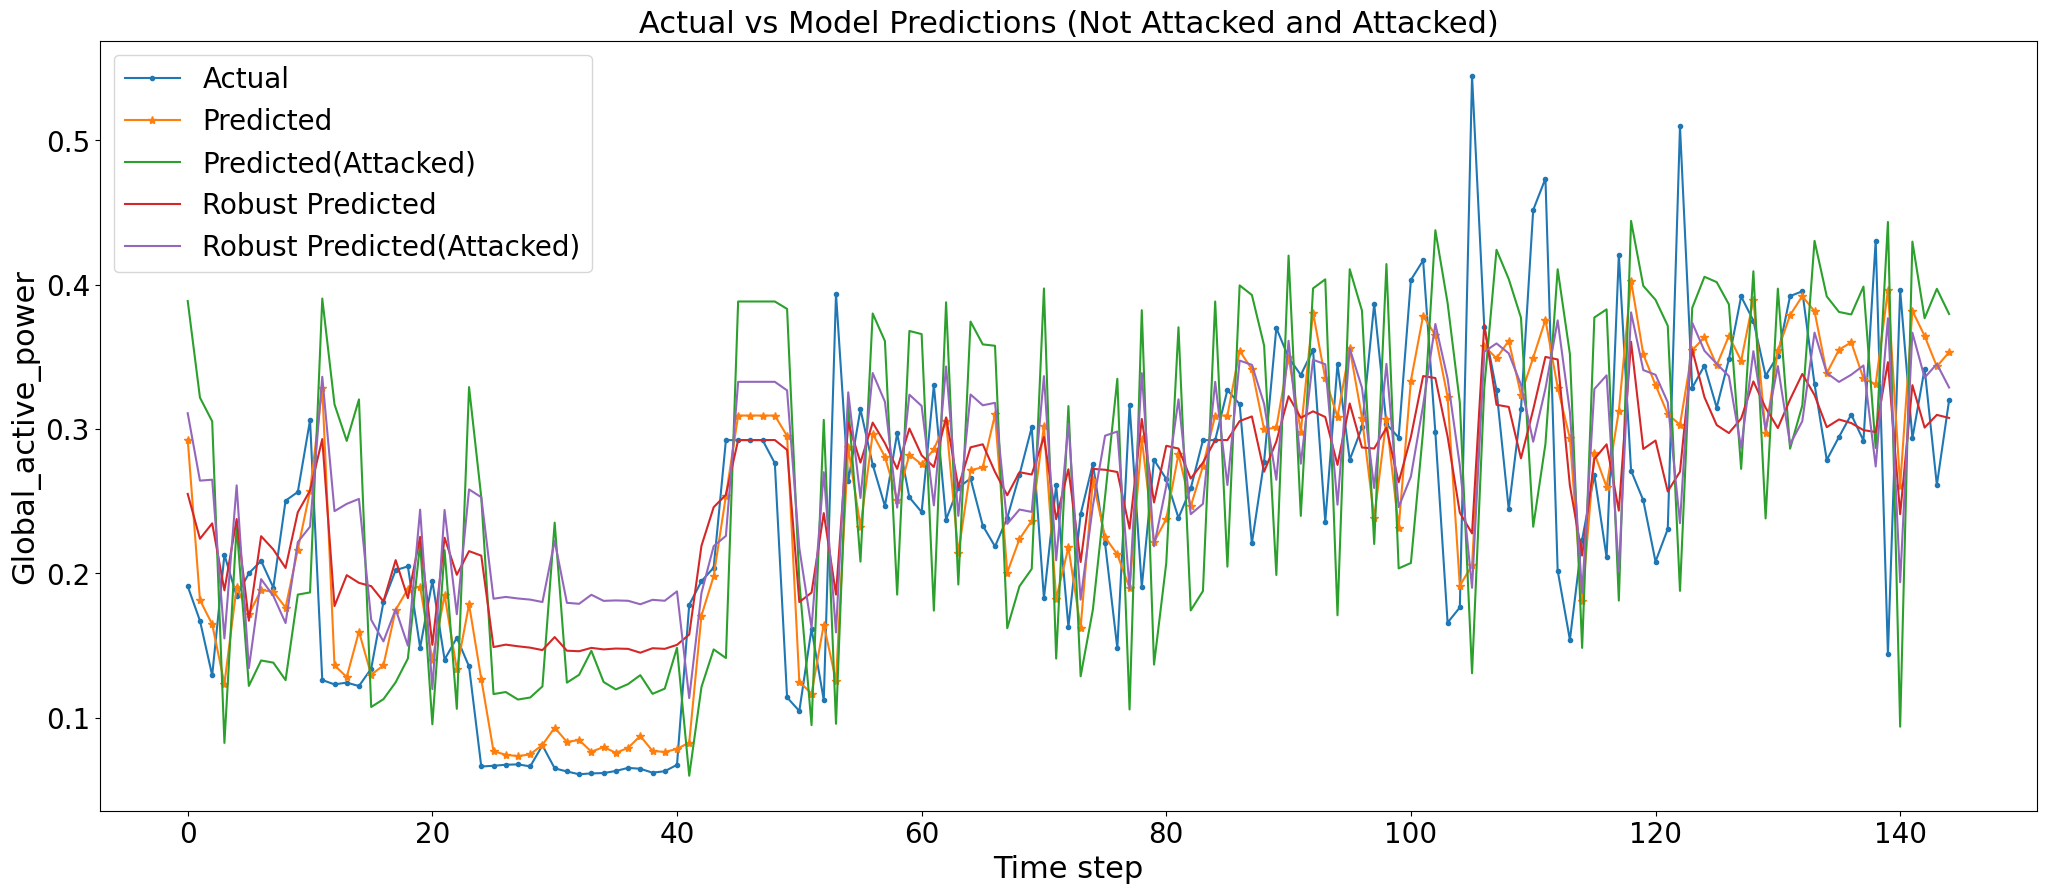

In [ ]:
plt.figure(figsize=(25, 10))
plt.ylabel('Global_active_power', fontsize=22)
plt.xlabel('Time step', fontsize=22)
plt.title("Actual vs Model Predictions (Not Attacked and Attacked)", fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(range(len(test_y)), test_y[:], marker=".", label="Actual")
plt.plot(range(len(pred_y_test)), pred_y_test[:], marker="*", label="Predicted")
plt.plot(range(len(test_pred_advy)), test_pred_advy[:], label="Predicted(Attacked)")
plt.plot(range(len(robust_pred_y_test)), robust_pred_y_test[:], label="Robust Predicted")
plt.plot(range(len(robust_test_pred_advy)), robust_test_pred_advy[:], label="Robust Predicted(Attacked)")
plt.legend(fontsize=20)
plt.show()

# BIM (Basic Iterative Method) attack

In [ ]:
def bim_attack(model, x, y, epsilon=0.05, alpha=0.01, iterations=10):
    """
    Implements the Basic Iterative Method attack.

    Args:
        model: The model to attack
        x: Original input
        y: Target output
        epsilon: Maximum perturbation
        alpha: Step size for each iteration
        iterations: Number of iterations

    Returns:
        Adversarial examples
    """
    advX = tf.identity(x)  # Create a copy of the input

    for i in range(iterations):
        with tf.GradientTape() as tape:
            tape.watch(advX)
            predictions = model(advX)
            loss = tf.keras.losses.MSE(y, predictions)

        # Get the gradients
        gradients = tape.gradient(loss, advX)

        # Create perturbation using sign of gradients (like FGSM)
        signed_grad = tf.sign(gradients)

        # Apply small perturbation in the direction of the gradient
        advX = advX + alpha * signed_grad

        # Project back to epsilon-ball around original x
        advX = tf.clip_by_value(advX, x - epsilon, x + epsilon)

        # Make sure we're still in valid input range [0,1]
        advX = tf.clip_by_value(advX, 0, 1)

    return advX

In [ ]:
# Generate BIM adversarial examples
print("Generating BIM adversarial examples...")
advX_bim = bim_attack(model, test_X, test_y, epsilon=0.1, alpha=0.01, iterations=10)

Generating BIM adversarial examples...


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis 3 of a tensor of shape (145, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


In [ ]:
# Evaluate the standard model on BIM adversarial examples
bim_attack_loss = model.evaluate(advX_bim, test_y)
print(f"Standard Model BIM Attack Loss: {bim_attack_loss[0]:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0211 - mae: 0.1355
Standard Model BIM Attack Loss: 0.0208


In [ ]:
# Generate predictions for visualization
bim_test_pred_advy = model.predict(advX_bim)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [ ]:
# Train a model robust to BIM attacks using adversarial training
print("Training a model robust to BIM attacks...")
robust_bim_model = build_model(
  input_shape=(1,7),
  head_size=256,
  num_heads=4,
  ff_dim=4,
  num_transformer_blocks=4,
  mlp_units=[128],
  mlp_dropout=0.4,
  dropout=0.25
)
robust_bim_model.compile(optimizer="adam", loss="mse", metrics=["mae"])

Training a model robust to BIM attacks...


In [ ]:
# Create adversarial examples for training
train_advX_bim = bim_attack(robust_bim_model, train_X, train_y,
                           epsilon=0.05, alpha=0.01, iterations=5)

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1036, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


In [ ]:
# Combine clean and adversarial examples for robust training
combined_X = tf.concat([train_X, train_advX_bim], axis=0)
combined_y = tf.concat([train_y, train_y], axis=0)

In [ ]:
# Train the robust model
robust_bim_model.fit(
    combined_X, combined_y,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ],
    verbose=1
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


59/59 ━━━━━━━━━━━━━━━━━━━━ 23s 67ms/step - loss: 0.0447 - mae: 0.1684 - val_loss: 0.0087 - val_mae: 0.0767
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0184 - mae: 0.1046 - val_loss: 0.0068 - val_mae: 0.0677
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0163 - mae: 0.0959 - val_loss: 0.0062 - val_mae: 0.0650
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0164 - mae: 0.0959 - val_loss: 0.0052 - val_mae: 0.0569
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0150 - mae: 0.0924 - val_loss: 0.0047 - val_mae: 0.0558
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0133 - mae: 0.0877 - val_loss: 0.0043 - val_mae: 0.0524
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0145 - mae: 0.0919 - val_loss: 0.0048 - val_mae: 0.0548
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0138 - mae: 0.0882 - val_loss: 0.0047 - val_mae: 0.0541
Epoch 9/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0140 - mae: 0

In [ ]:
# Evaluate the robust model on clean test data
robust_bim_test_loss = robust_bim_model.evaluate(test_X, test_y)
print(f"Robust BIM Model Test Loss: {robust_bim_test_loss[0]:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0054 - mae: 0.0583
Robust BIM Model Test Loss: 0.0063


In [ ]:
# Evaluate the robust model on BIM adversarial examples
robust_bim_attack_loss = robust_bim_model.evaluate(advX_bim, test_y)
print(f"Robust BIM Model Attack Loss: {robust_bim_attack_loss[0]:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0283 - mae: 0.1592
Robust BIM Model Attack Loss: 0.0282


In [ ]:
# Quantize the BIM-robust model
bim_robust_quantized_path = convert_to_tflite(
    robust_model,  # BIM-robust model after adversarial training
    quantized_model_folder,
    model_name="float16_quantized_bim_robust_model.tflite"
)

Saved artifact at '/tmp/tmpux2kby1b'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 1, 7), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  138159593180048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138159593181200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138159593178320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138159593177936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138159593181584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138159593181008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138159593182160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138159593182544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138159593183312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138159593181392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138159593184272: Tens

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Save the BIM-robust model to a separate folder for unquantized models
unquantized_model_folder = "/content/drive/MyDrive/PES/unquantized_models"
os.makedirs(unquantized_model_folder, exist_ok=True)  # Ensure the folder exists

# Save the unquantized BIM-robust model
bim_robust_model_path = os.path.join(unquantized_model_folder, "bim_robust_model.keras")
robust_bim_model.save(bim_robust_model_path)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


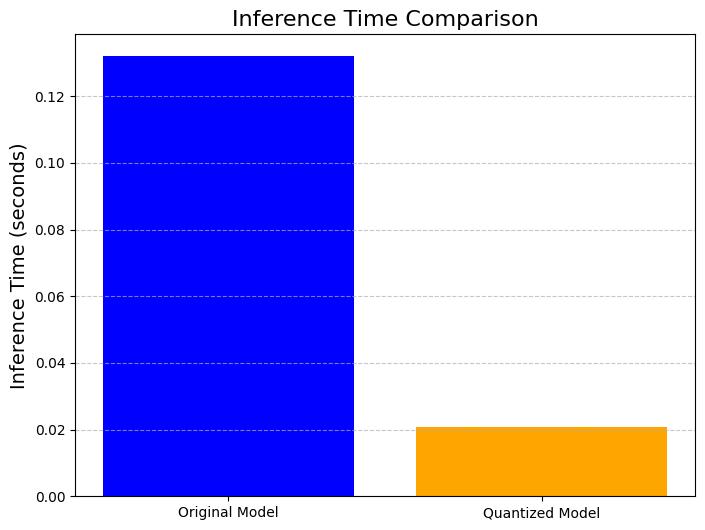

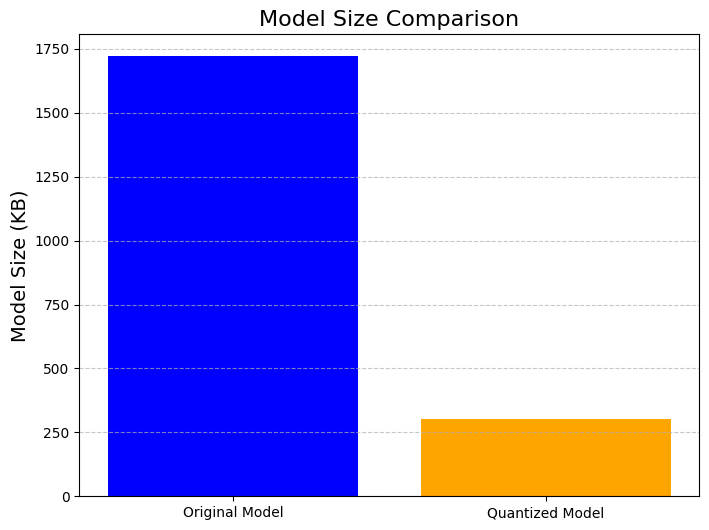

BIM-Robust Model Inference Time (Original): 0.1320 seconds
BIM-Robust Model Inference Time (Quantized): 0.0207 seconds
BIM-Robust Model Size (Original): 1720.89 KB
BIM-Robust Model Size (Quantized): 303.19 KB


In [ ]:
# Measure inference time for BIM-robust model on clean test data
bim_robust_time_original = measure_inference_time_original(robust_bim_model, test_X)
bim_robust_time_quantized = measure_inference_time_quantized(bim_robust_quantized_path, test_X)

# Get model sizes
bim_robust_original_size = get_model_size(bim_robust_model_path)
bim_robust_quantized_size = get_model_size(bim_robust_quantized_path)

# Plot inference time comparison for BIM-robust model
plot_inference_time(bim_robust_time_original, bim_robust_time_quantized)

# Plot model size comparison for BIM-robust model
plot_model_size(bim_robust_original_size, bim_robust_quantized_size)

# Print results for BIM-robust model
print(f"BIM-Robust Model Inference Time (Original): {bim_robust_time_original:.4f} seconds")
print(f"BIM-Robust Model Inference Time (Quantized): {bim_robust_time_quantized:.4f} seconds")
print(f"BIM-Robust Model Size (Original): {bim_robust_original_size:.2f} KB")
print(f"BIM-Robust Model Size (Quantized): {bim_robust_quantized_size:.2f} KB")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


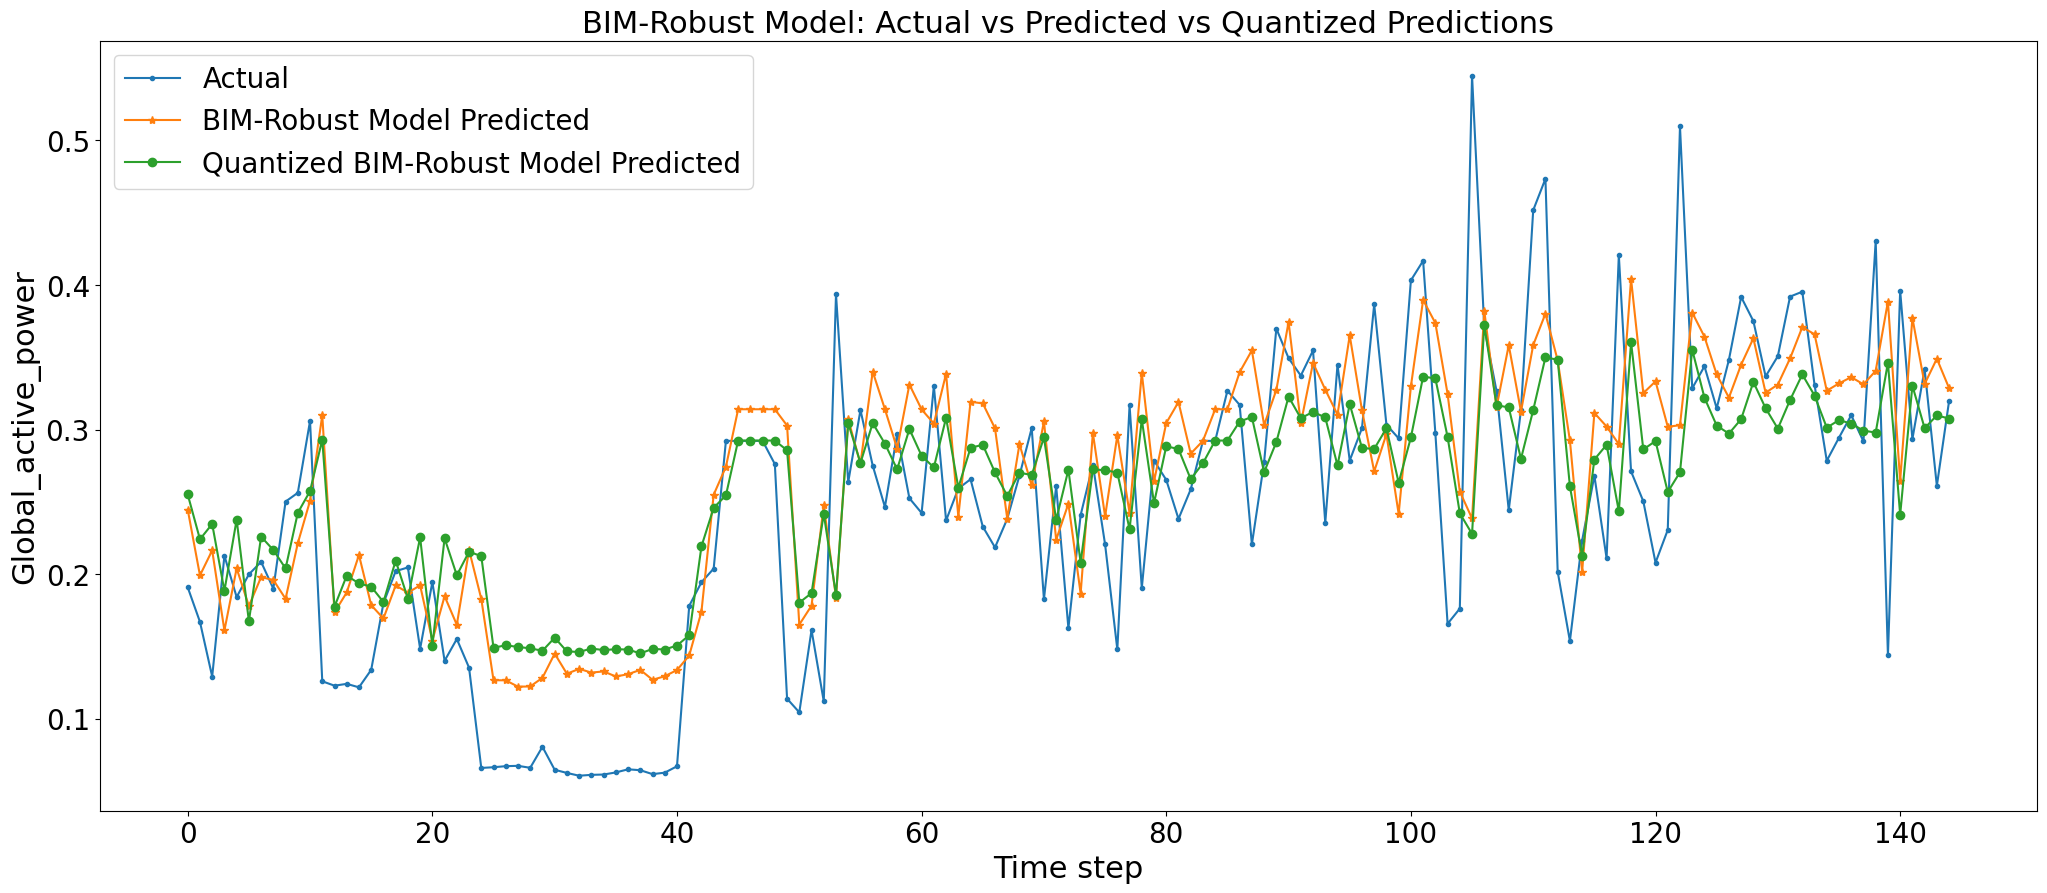

Actual Values (first 5): [0.19095185 0.16706197 0.12922366 0.21276482 0.18420601]
BIM-Robust Model Predictions (first 5): [[0.24466375]
 [0.19919339]
 [0.21646667]
 [0.1611146 ]
 [0.20407346]]
Quantized BIM-Robust Model Predictions (first 5): [[0.25514567]
 [0.22415933]
 [0.23474523]
 [0.18848254]
 [0.23774232]]


In [ ]:
# Generate predictions with the quantized BIM-robust model
quantized_bim_robust_predictions = load_and_predict_tflite_model(bim_robust_quantized_path, test_X)

# Plot predictions for BIM-robust model (original vs quantized)
plt.figure(figsize=(25, 10))
plt.ylabel('Global_active_power', fontsize=22)
plt.xlabel('Time step', fontsize=22)
plt.title("BIM-Robust Model: Actual vs Predicted vs Quantized Predictions", fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Plot actual values
plt.plot(range(len(test_y)), test_y[:], marker=".", label="Actual")

# Plot BIM-robust model predictions
bim_robust_pred_y_test = robust_bim_model.predict(test_X)
plt.plot(range(len(bim_robust_pred_y_test)), bim_robust_pred_y_test[:], marker="*", label="BIM-Robust Model Predicted")

# Plot quantized BIM-robust model predictions
plt.plot(range(len(quantized_bim_robust_predictions)), quantized_bim_robust_predictions[:], marker="o", label="Quantized BIM-Robust Model Predicted")

# Add legend and show the plot
plt.legend(fontsize=20)
plt.show()

# Print first few actual values, BIM-robust predictions, and quantized BIM-robust predictions
print("Actual Values (first 5):", test_y[:5])
print("BIM-Robust Model Predictions (first 5):", bim_robust_pred_y_test[:5])
print("Quantized BIM-Robust Model Predictions (first 5):", quantized_bim_robust_predictions[:5])

BIM-Robust Prediction Differences (first 5): [[-0.01048192]
 [-0.02496594]
 [-0.01827857]
 [-0.02736793]
 [-0.03366886]]


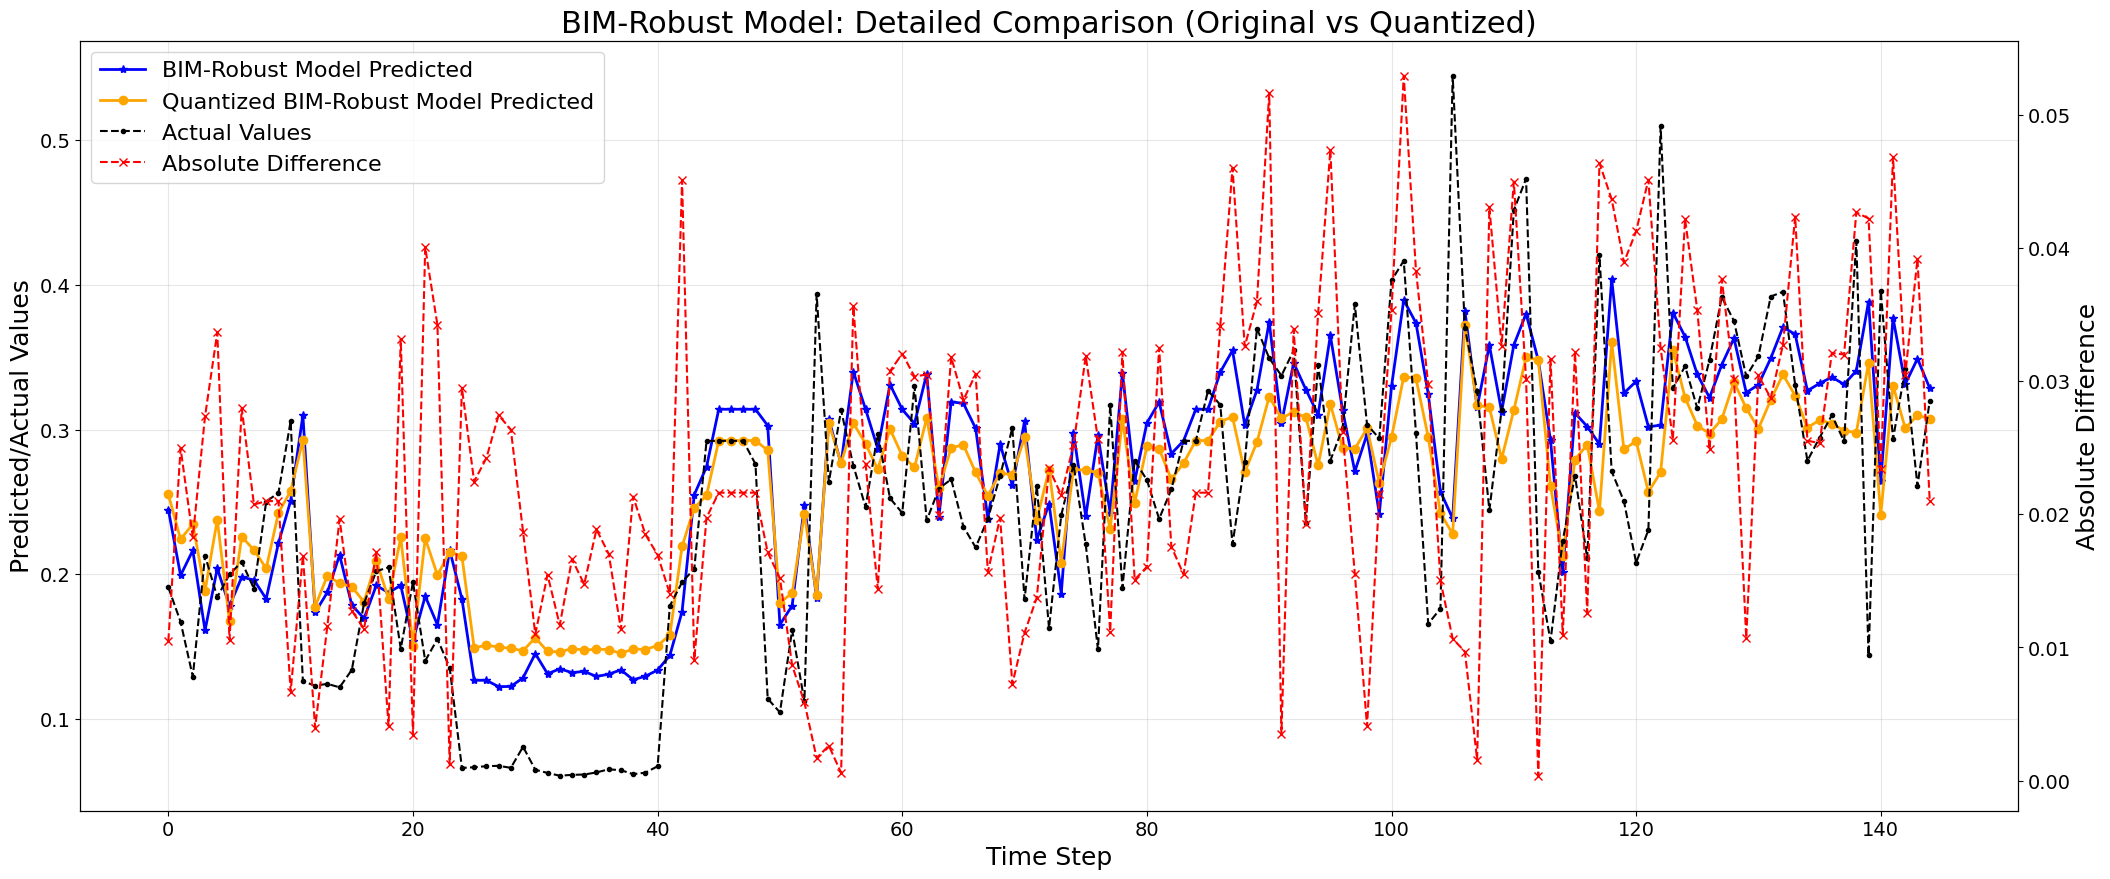

In [ ]:
# Check for differences between BIM-robust and quantized BIM-robust predictions
bim_robust_diff = bim_robust_pred_y_test - quantized_bim_robust_predictions
print("BIM-Robust Prediction Differences (first 5):", bim_robust_diff[:5])

# Calculate the absolute differences
bim_robust_diff_abs = np.abs(bim_robust_pred_y_test - quantized_bim_robust_predictions)

# Create a figure with a secondary y-axis for the differences
fig, ax1 = plt.subplots(figsize=(25, 10))

# Plot the BIM-robust model predictions
ax1.plot(range(len(bim_robust_pred_y_test)), bim_robust_pred_y_test[:], marker="*", label="BIM-Robust Model Predicted", color="blue", linewidth=2)

# Plot the quantized BIM-robust model predictions
ax1.plot(range(len(quantized_bim_robust_predictions)), quantized_bim_robust_predictions[:], marker="o", label="Quantized BIM-Robust Model Predicted", color="orange", linewidth=2)

# Plot actual values
ax1.plot(range(len(test_y)), test_y[:], marker=".", label="Actual Values", color="black", linestyle="--", linewidth=1.5)

# Label the primary y-axis
ax1.set_ylabel('Predicted/Actual Values', fontsize=18)
ax1.set_xlabel('Time Step', fontsize=18)

# Add a secondary y-axis for the differences
ax2 = ax1.twinx()
ax2.plot(range(len(bim_robust_diff_abs)), bim_robust_diff_abs, marker="x", label="Absolute Difference", color="red", linestyle="--", linewidth=1.5)
ax2.set_ylabel('Absolute Difference', fontsize=18)

# Add a title and grid
plt.title("BIM-Robust Model: Detailed Comparison (Original vs Quantized)", fontsize=22)
ax1.grid(alpha=0.3)

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
plt.legend(lines1 + lines2, labels1 + labels2, fontsize=16, loc="upper left")

# Adjust tick sizes
ax1.tick_params(axis="both", labelsize=14)
ax2.tick_params(axis="y", labelsize=14)

# Show the plot
plt.show()


In [ ]:
# Inspect the quantized BIM-robust model
interpreter = tf.lite.Interpreter(model_path=bim_robust_quantized_path)
interpreter.allocate_tensors()

# Print input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input Details [BIM-Robust]:", input_details)
print("Output Details [BIM-Robust]:", output_details)

Input Details [BIM-Robust]: [{'name': 'serving_default_keras_tensor:0', 'index': 0, 'shape': array([1, 1, 7], dtype=int32), 'shape_signature': array([-1,  1,  7], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output Details [BIM-Robust]: [{'name': 'StatefulPartitionedCall_1:0', 'index': 353, 'shape': array([1, 1], dtype=int32), 'shape_signature': array([-1,  1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [ ]:
# Compare performance metrics for BIM-robust model
bim_robust_mse_original = tf.keras.losses.MeanSquaredError()(test_y, bim_robust_pred_y_test).numpy()
bim_robust_mse_quantized = tf.keras.losses.MeanSquaredError()(test_y, quantized_bim_robust_predictions).numpy()
print(f"BIM-Robust Model MSE (Original): {bim_robust_mse_original:.4f}")
print(f"BIM-Robust Model MSE (Quantized): {bim_robust_mse_quantized:.4f}")

# Calculate overall MAE for BIM-robust model
bim_robust_mae_original = mean_absolute_error(test_y, bim_robust_pred_y_test)
bim_robust_mae_quantized = mean_absolute_error(test_y, quantized_bim_robust_predictions)

# Print the overall MAE values
print(f"BIM-Robust Model MAE (Original): {bim_robust_mae_original:.6f}")
print(f"BIM-Robust Model MAE (Quantized): {bim_robust_mae_quantized:.6f}")

# Data for the bar graph
metrics = ['MAE', 'RMSE', 'MSE']
original_values = [bim_robust_mae_original, np.sqrt(bim_robust_mse_original), bim_robust_mse_original]
quantized_values = [bim_robust_mae_quantized, np.sqrt(bim_robust_mse_quantized), bim_robust_mse_quantized]

BIM-Robust Model MSE (Original): 0.0063
BIM-Robust Model MSE (Quantized): 0.0063
BIM-Robust Model MAE (Original): 0.061280
BIM-Robust Model MAE (Quantized): 0.060367


BIM-Robust Model MAE (Original): 0.061279696244
BIM-Robust Model MAE (Quantized): 0.060367424810
BIM-Robust Model RMSE (Original): 0.079508674730
BIM-Robust Model RMSE (Quantized): 0.079108237790
BIM-Robust Model MSE (Original): 0.006321629357
BIM-Robust Model MSE (Quantized): 0.006258113286


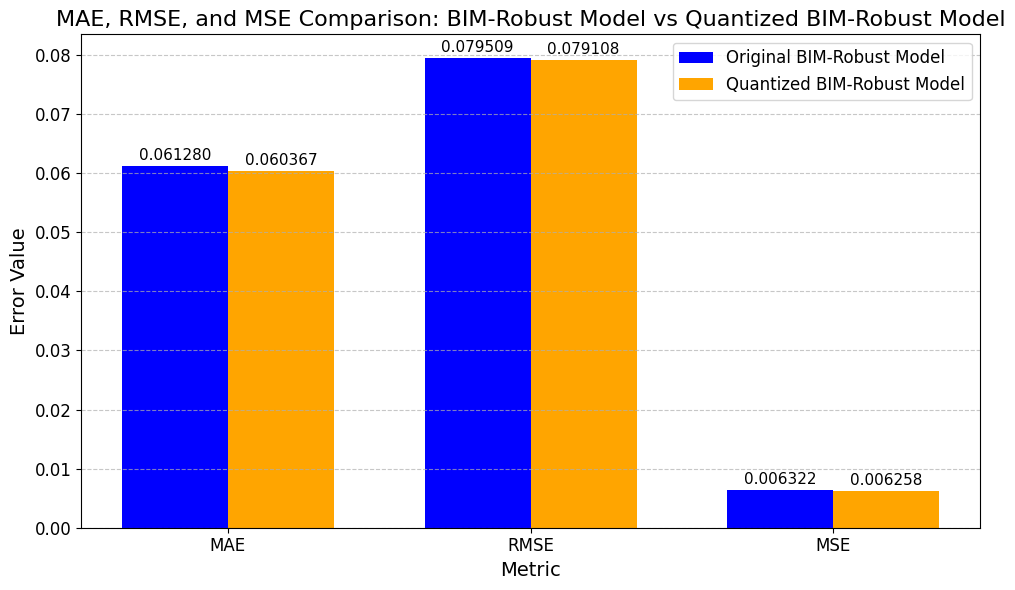

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Calculate MAE, RMSE, and MSE for BIM-robust model
bim_robust_mae_original = mean_absolute_error(test_y, bim_robust_pred_y_test)
bim_robust_mae_quantized = mean_absolute_error(test_y, quantized_bim_robust_predictions)

bim_robust_rmse_original = np.sqrt(mean_squared_error(test_y, bim_robust_pred_y_test))
bim_robust_rmse_quantized = np.sqrt(mean_squared_error(test_y, quantized_bim_robust_predictions))

bim_robust_mse_original = mean_squared_error(test_y, bim_robust_pred_y_test)
bim_robust_mse_quantized = mean_squared_error(test_y, quantized_bim_robust_predictions)

# Print the MAE, RMSE, and MSE values with high precision for the console (10+ decimal places)
print(f"BIM-Robust Model MAE (Original): {bim_robust_mae_original:.12f}")
print(f"BIM-Robust Model MAE (Quantized): {bim_robust_mae_quantized:.12f}")
print(f"BIM-Robust Model RMSE (Original): {bim_robust_rmse_original:.12f}")
print(f"BIM-Robust Model RMSE (Quantized): {bim_robust_rmse_quantized:.12f}")
print(f"BIM-Robust Model MSE (Original): {bim_robust_mse_original:.12f}")
print(f"BIM-Robust Model MSE (Quantized): {bim_robust_mse_quantized:.12f}")

# Data for the bar graph
metrics = ['MAE', 'RMSE', 'MSE']
original_values = [bim_robust_mae_original, bim_robust_rmse_original, bim_robust_mse_original]
quantized_values = [bim_robust_mae_quantized, bim_robust_rmse_quantized, bim_robust_mse_quantized]

# Create a grouped bar graph for MAE, RMSE, and MSE
x = np.arange(len(metrics))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, original_values, width, label='Original BIM-Robust Model', color='blue')
bars2 = ax.bar(x + width/2, quantized_values, width, label='Quantized BIM-Robust Model', color='orange')

# Add labels and title
ax.set_ylabel('Error Value', fontsize=14)
ax.set_xlabel('Metric', fontsize=14)
ax.set_title('MAE, RMSE, and MSE Comparison: BIM-Robust Model vs Quantized BIM-Robust Model', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=12)
ax.legend(fontsize=12)

# Add gridlines for better visualization
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Add values on top of the bars (6 decimal places for precision)
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2.0, height + 0.001, f"{height:.6f}", ha='center', fontsize=11)

# Show the plot
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

NameError: name 'robust_bim_pred_y_test' is not defined

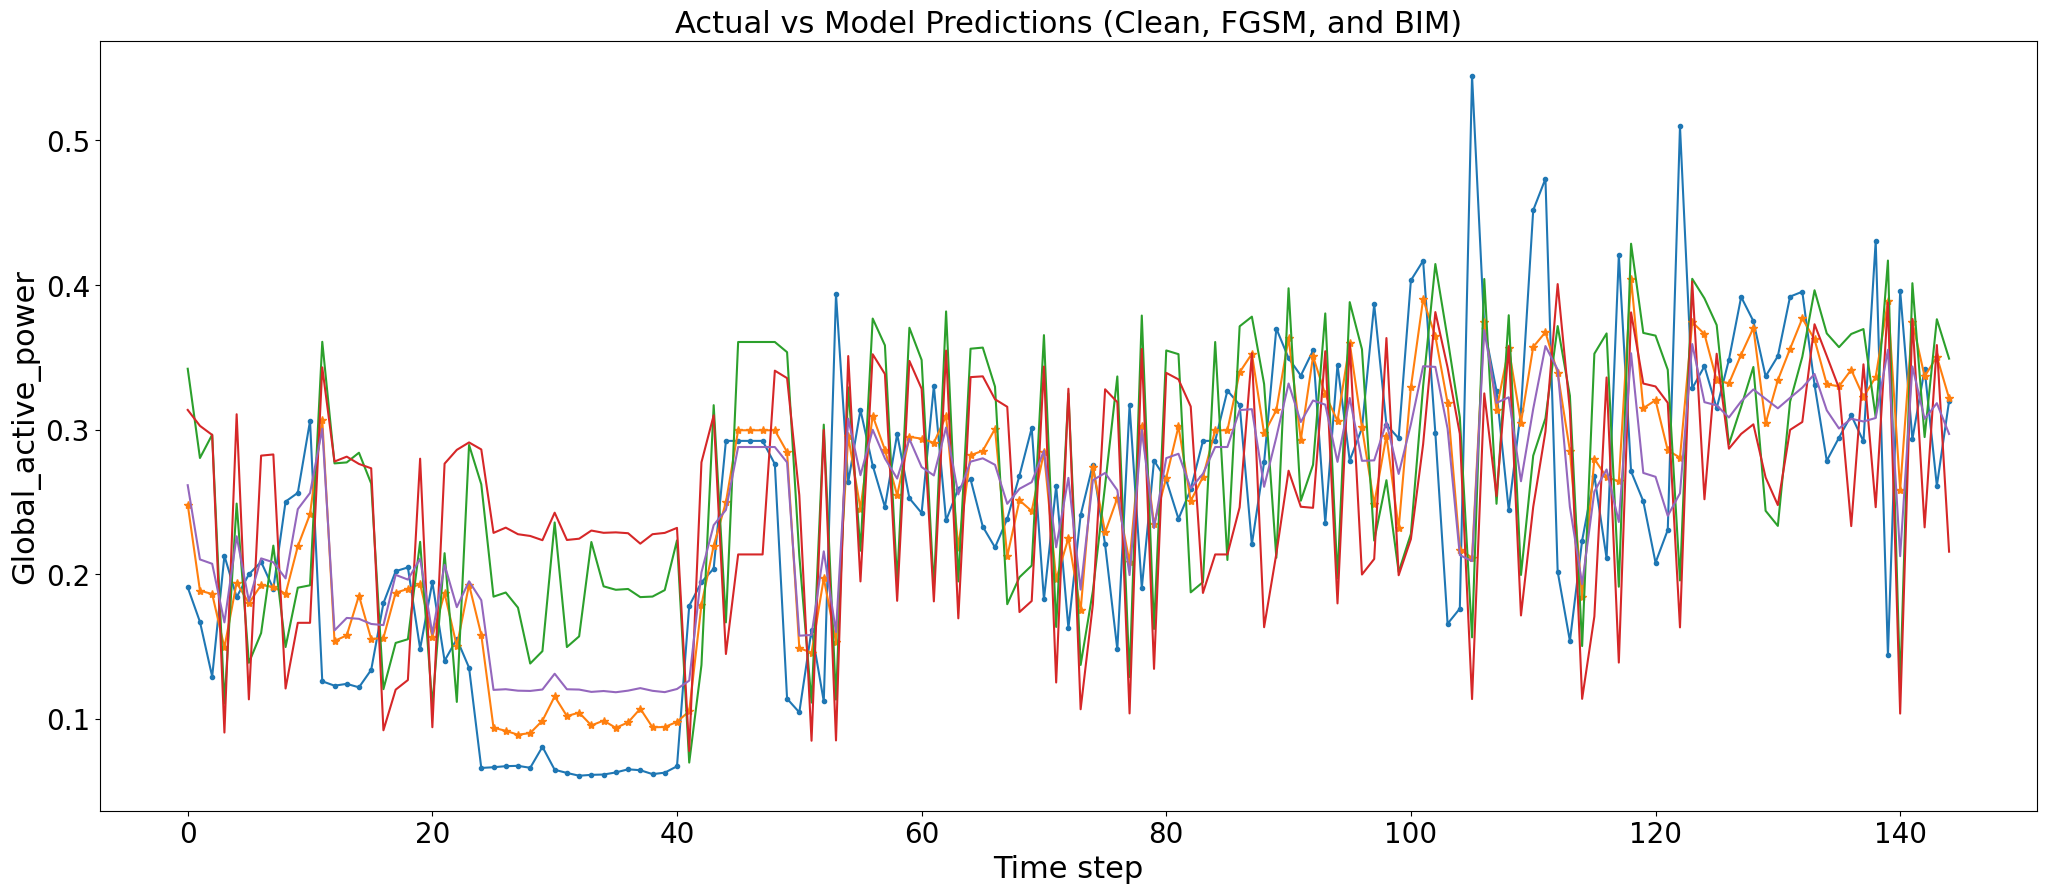

In [ ]:
# Visualize results including BIM attack
plt.figure(figsize=(25, 10))
plt.ylabel('Global_active_power', fontsize=22)
plt.xlabel('Time step', fontsize=22)
plt.title("Actual vs Model Predictions (Clean, FGSM, and BIM)", fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(range(len(test_y)), test_y[:], marker=".", label="Actual")
plt.plot(range(len(pred_y_test)), pred_y_test[:], marker="*", label="Standard Predicted")
plt.plot(range(len(test_pred_advy)), test_pred_advy[:], label="FGSM Attack")
plt.plot(range(len(bim_test_pred_advy)), bim_test_pred_advy[:], label="BIM Attack")
plt.plot(range(len(robust_pred_y_test)), robust_pred_y_test[:], label="FGSM-Robust Predicted")
plt.plot(range(len(robust_bim_pred_y_test)), robust_bim_pred_y_test[:], label="BIM-Robust Predicted")
plt.legend(fontsize=20)
plt.show()

In [ ]:
from tensorflow.keras.losses import MeanSquaredError

Running BIM attack with epsilon = 0.05
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Epsilon: 0.05, RMSE: 0.1387, MSE: 0.0192


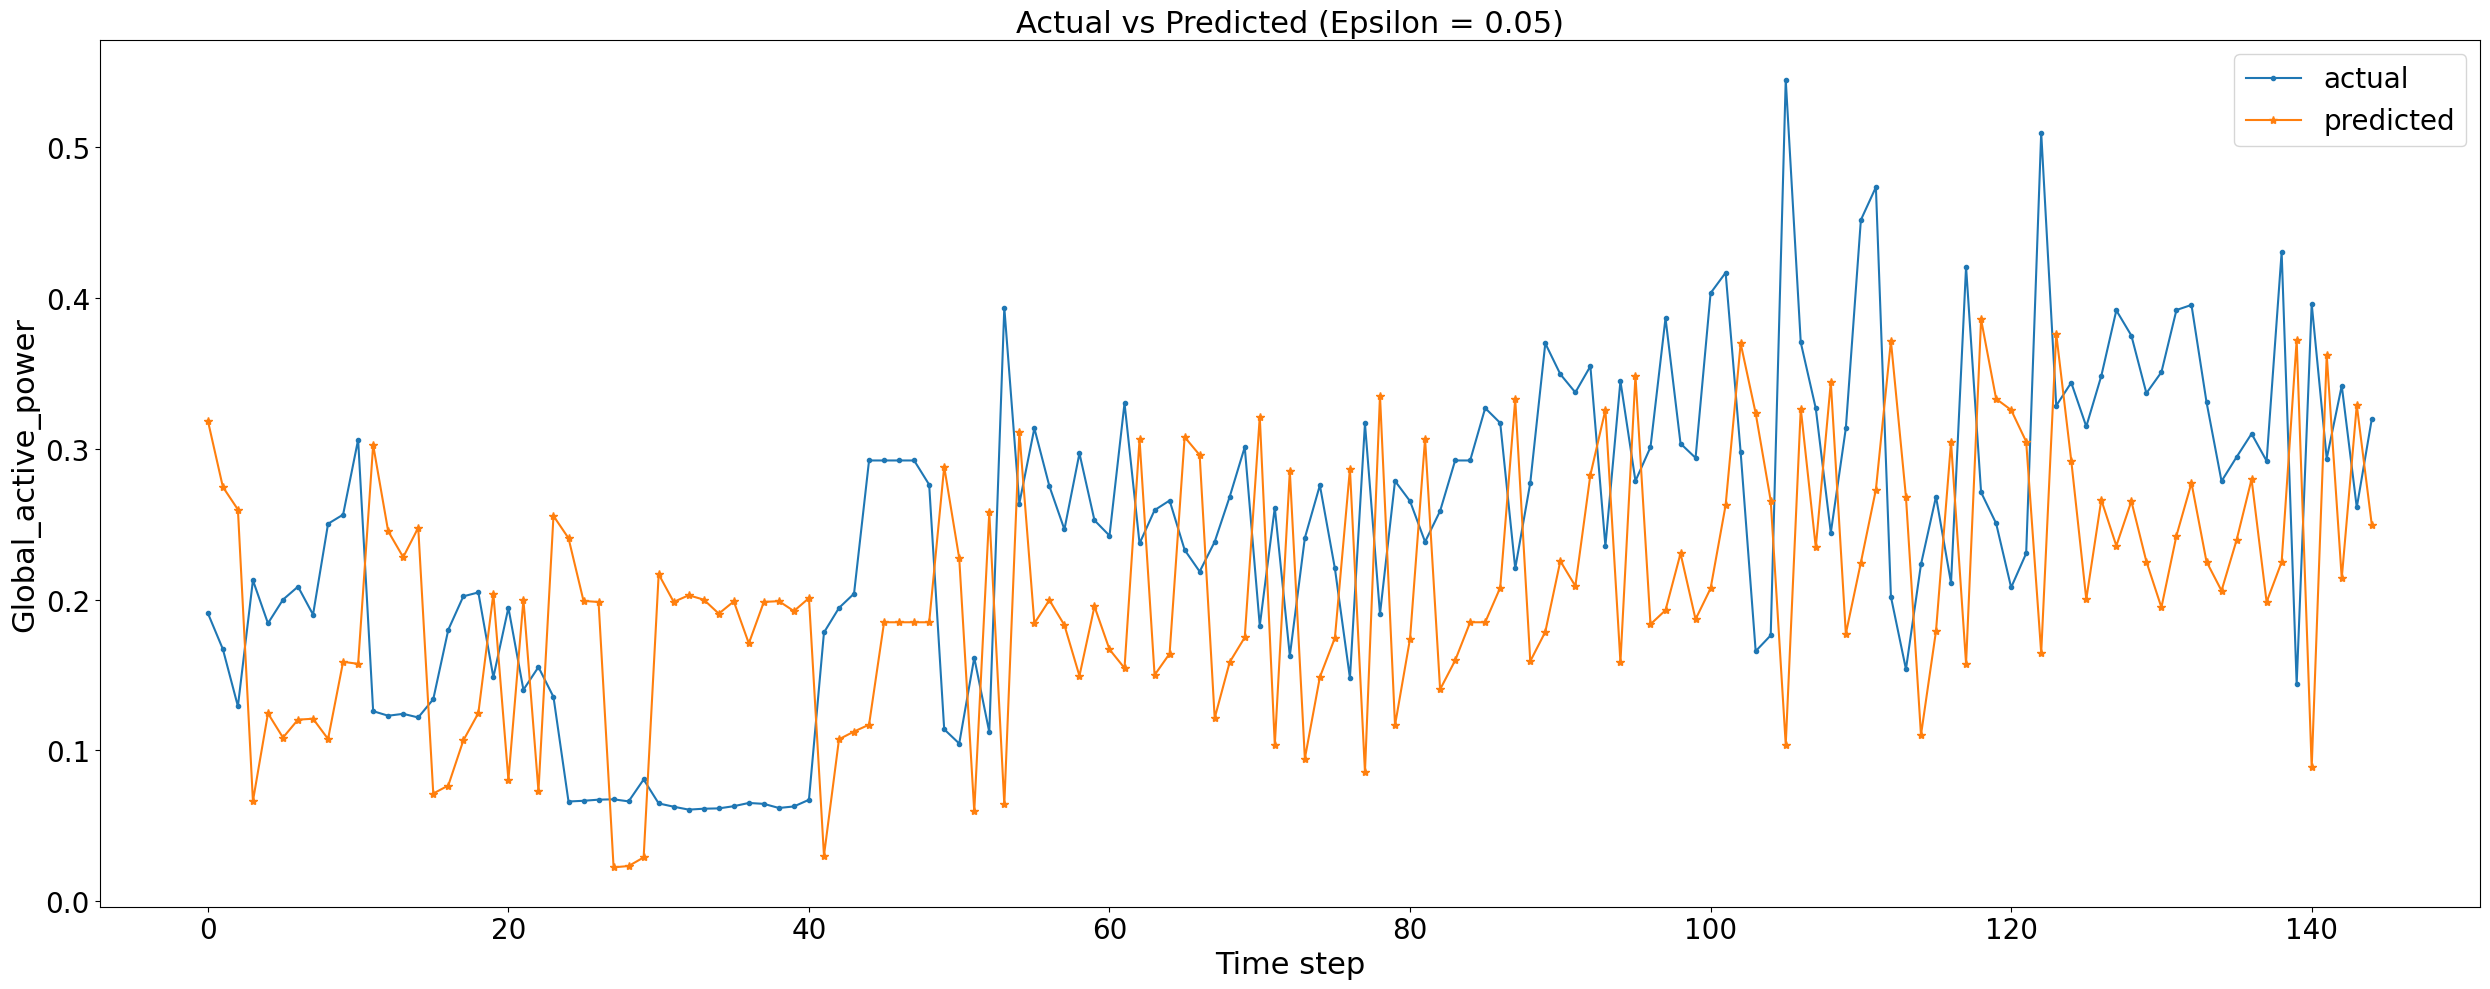

Running BIM attack with epsilon = 0.1


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis 3 of a tensor of shape (145, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Epsilon: 0.1, RMSE: 0.1574, MSE: 0.0248


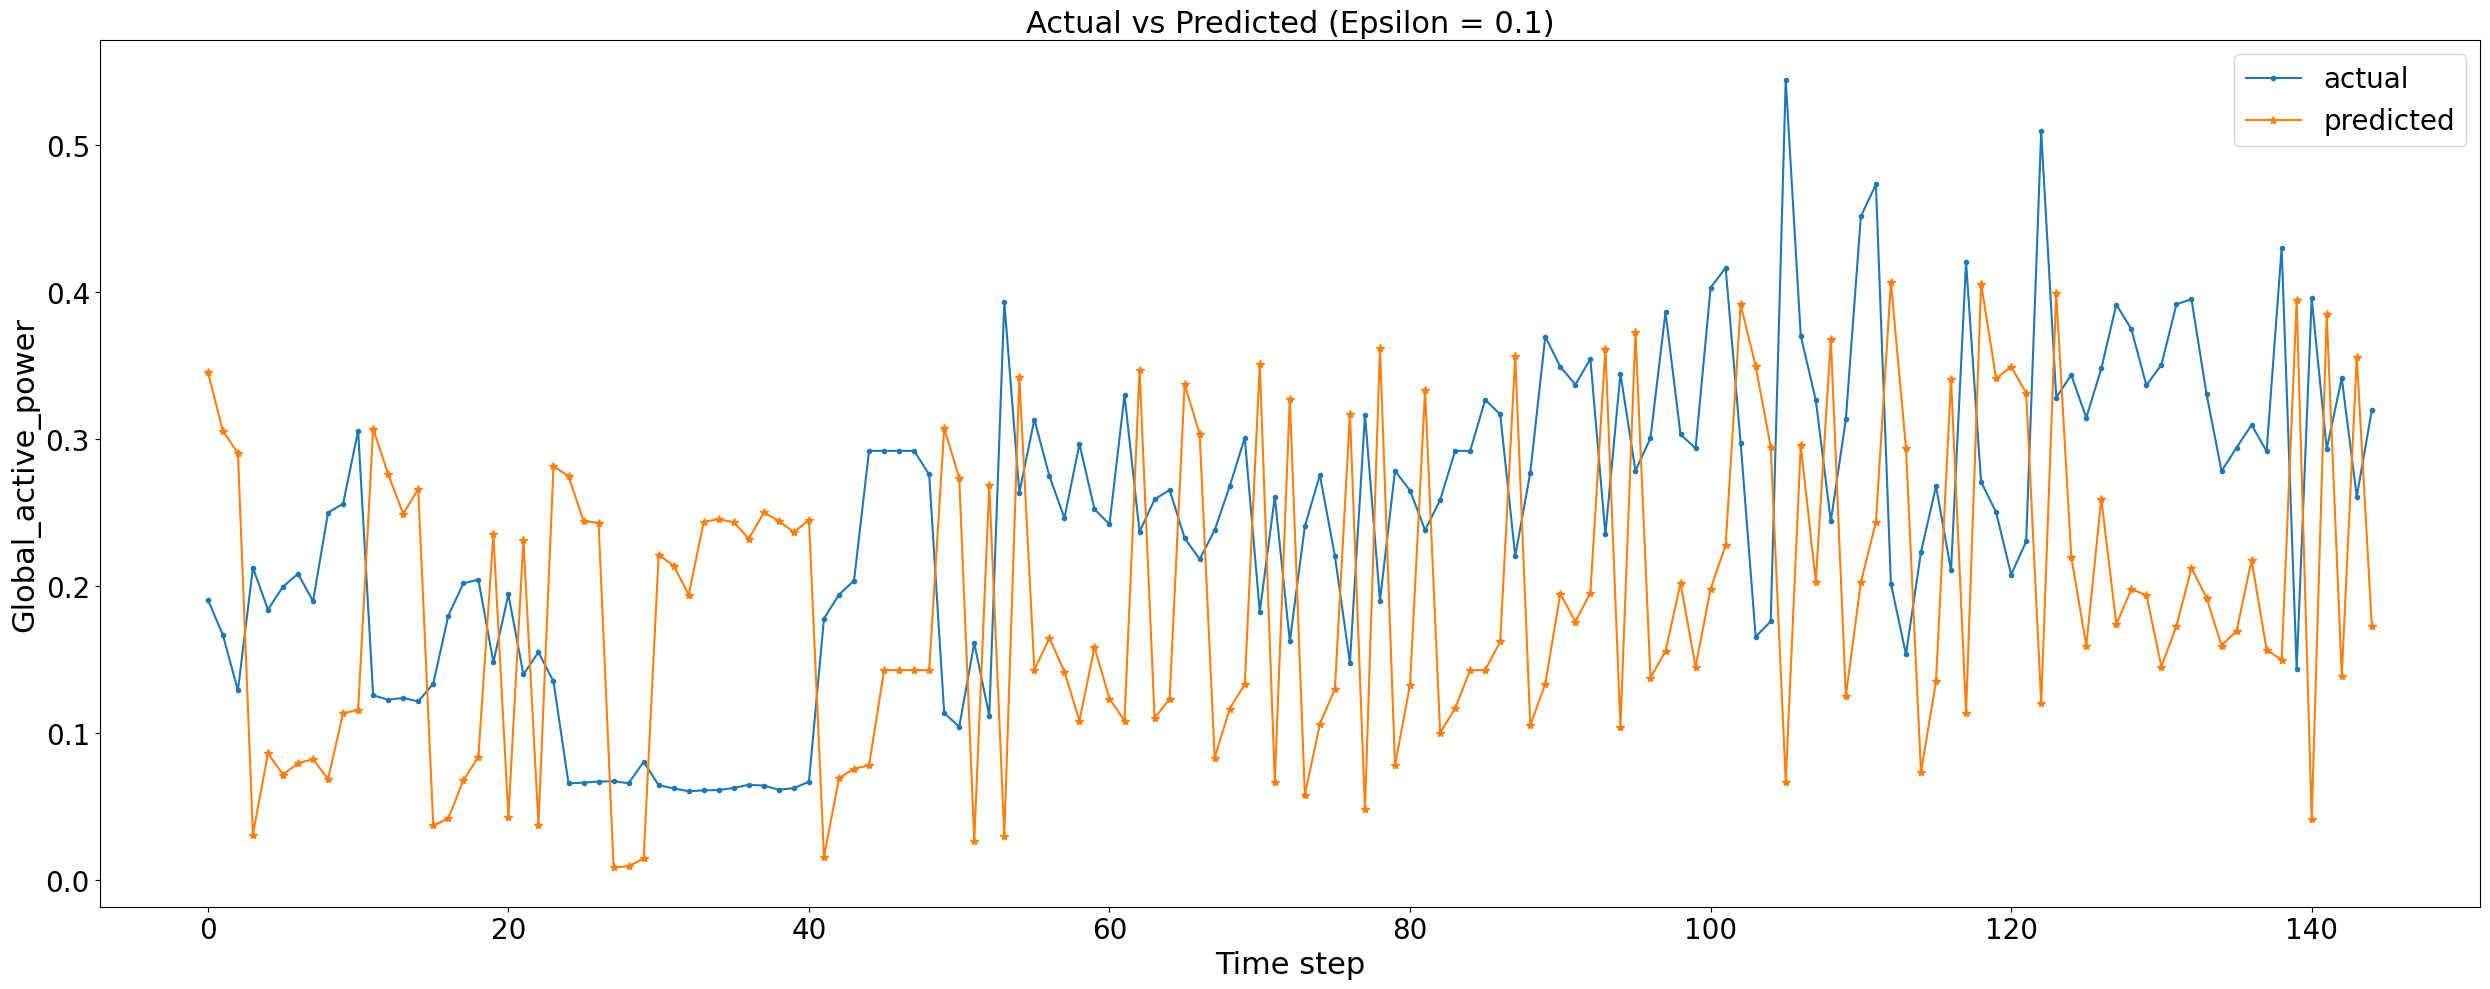

Running BIM attack with epsilon = 0.15


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis 3 of a tensor of shape (145, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Epsilon: 0.15, RMSE: 0.1574, MSE: 0.0248


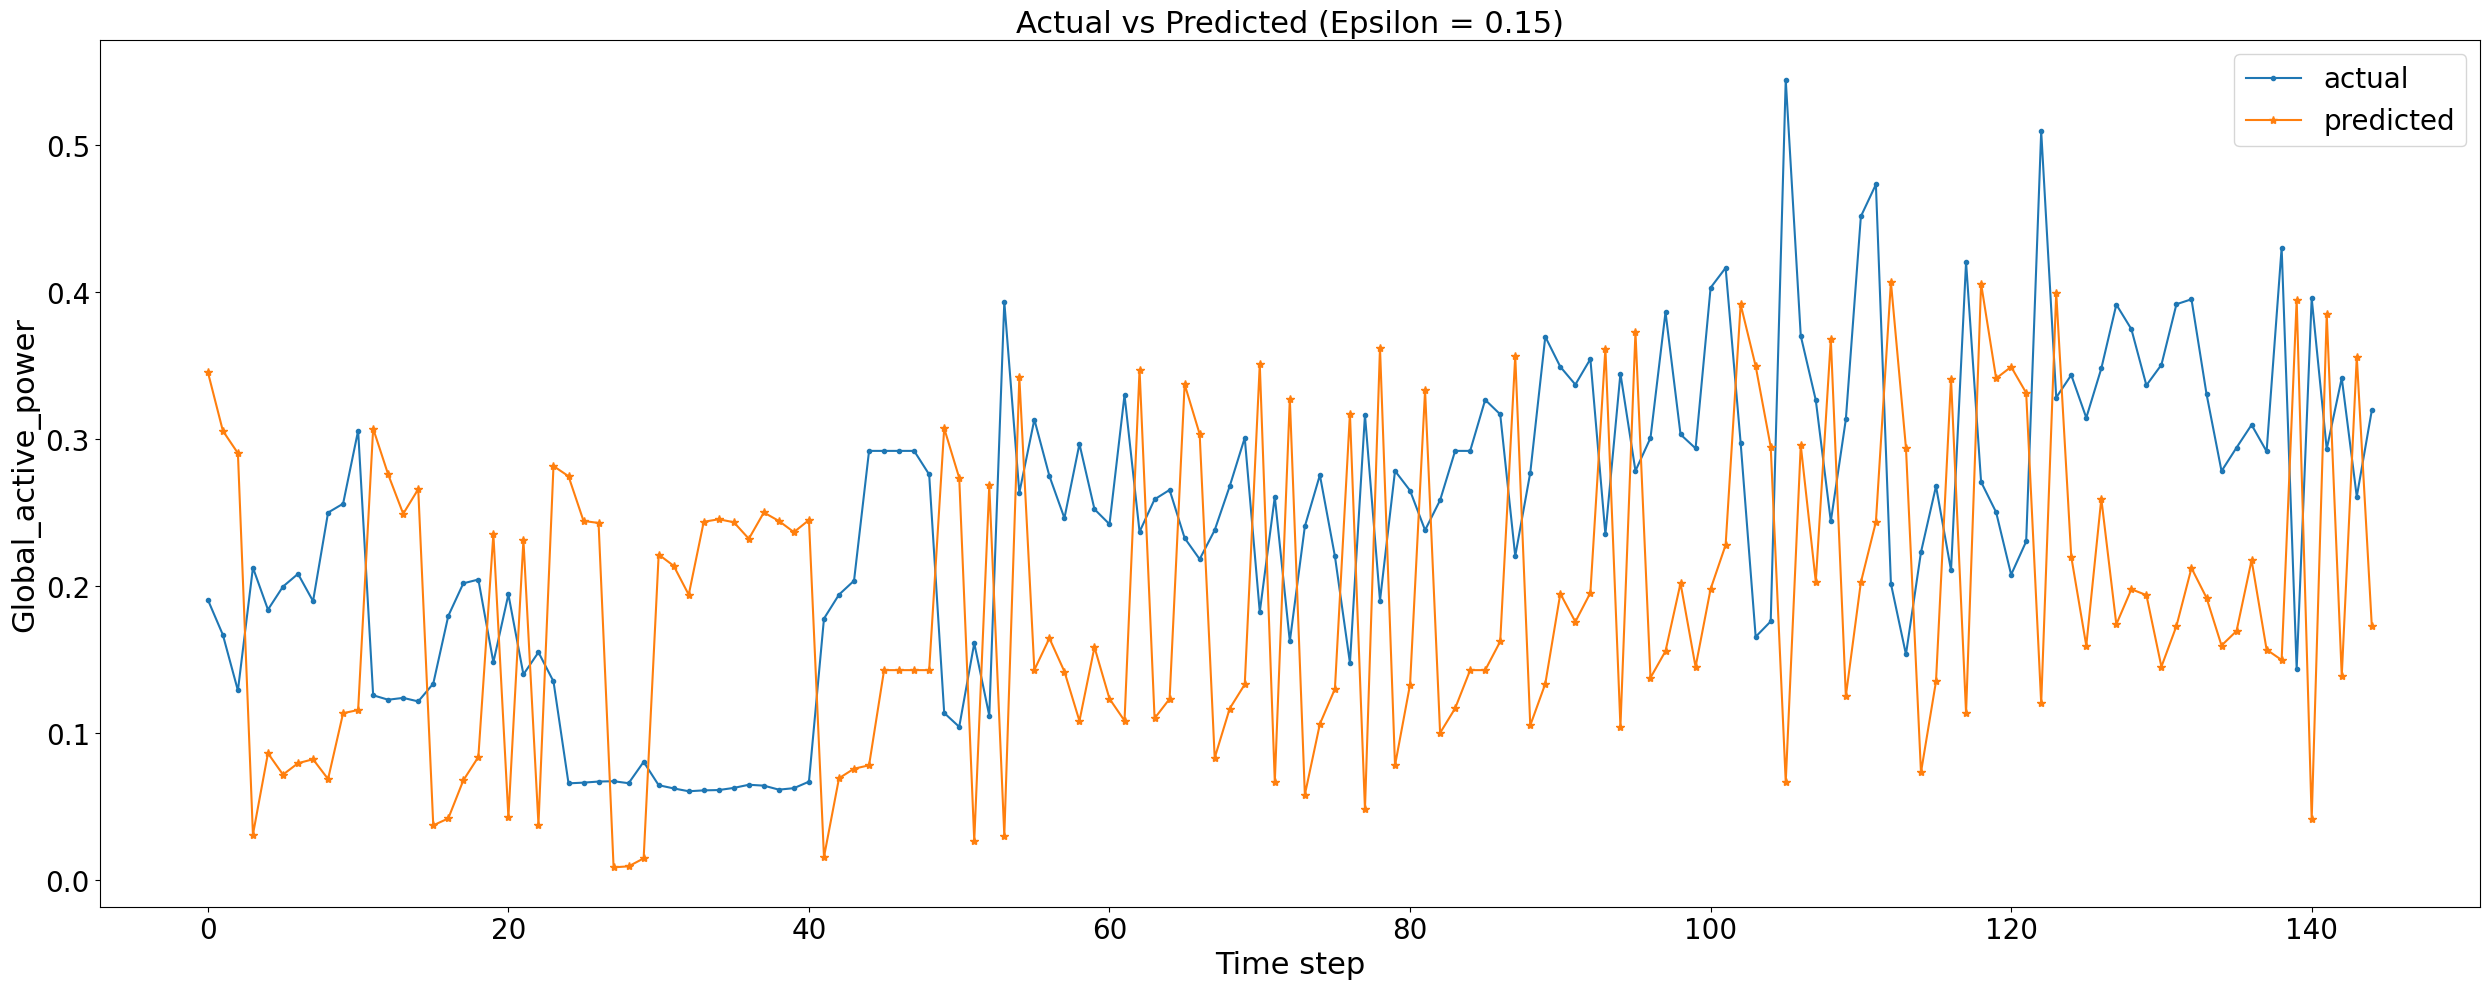

Running BIM attack with epsilon = 0.2


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis 3 of a tensor of shape (145, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Epsilon: 0.2, RMSE: 0.1574, MSE: 0.0248


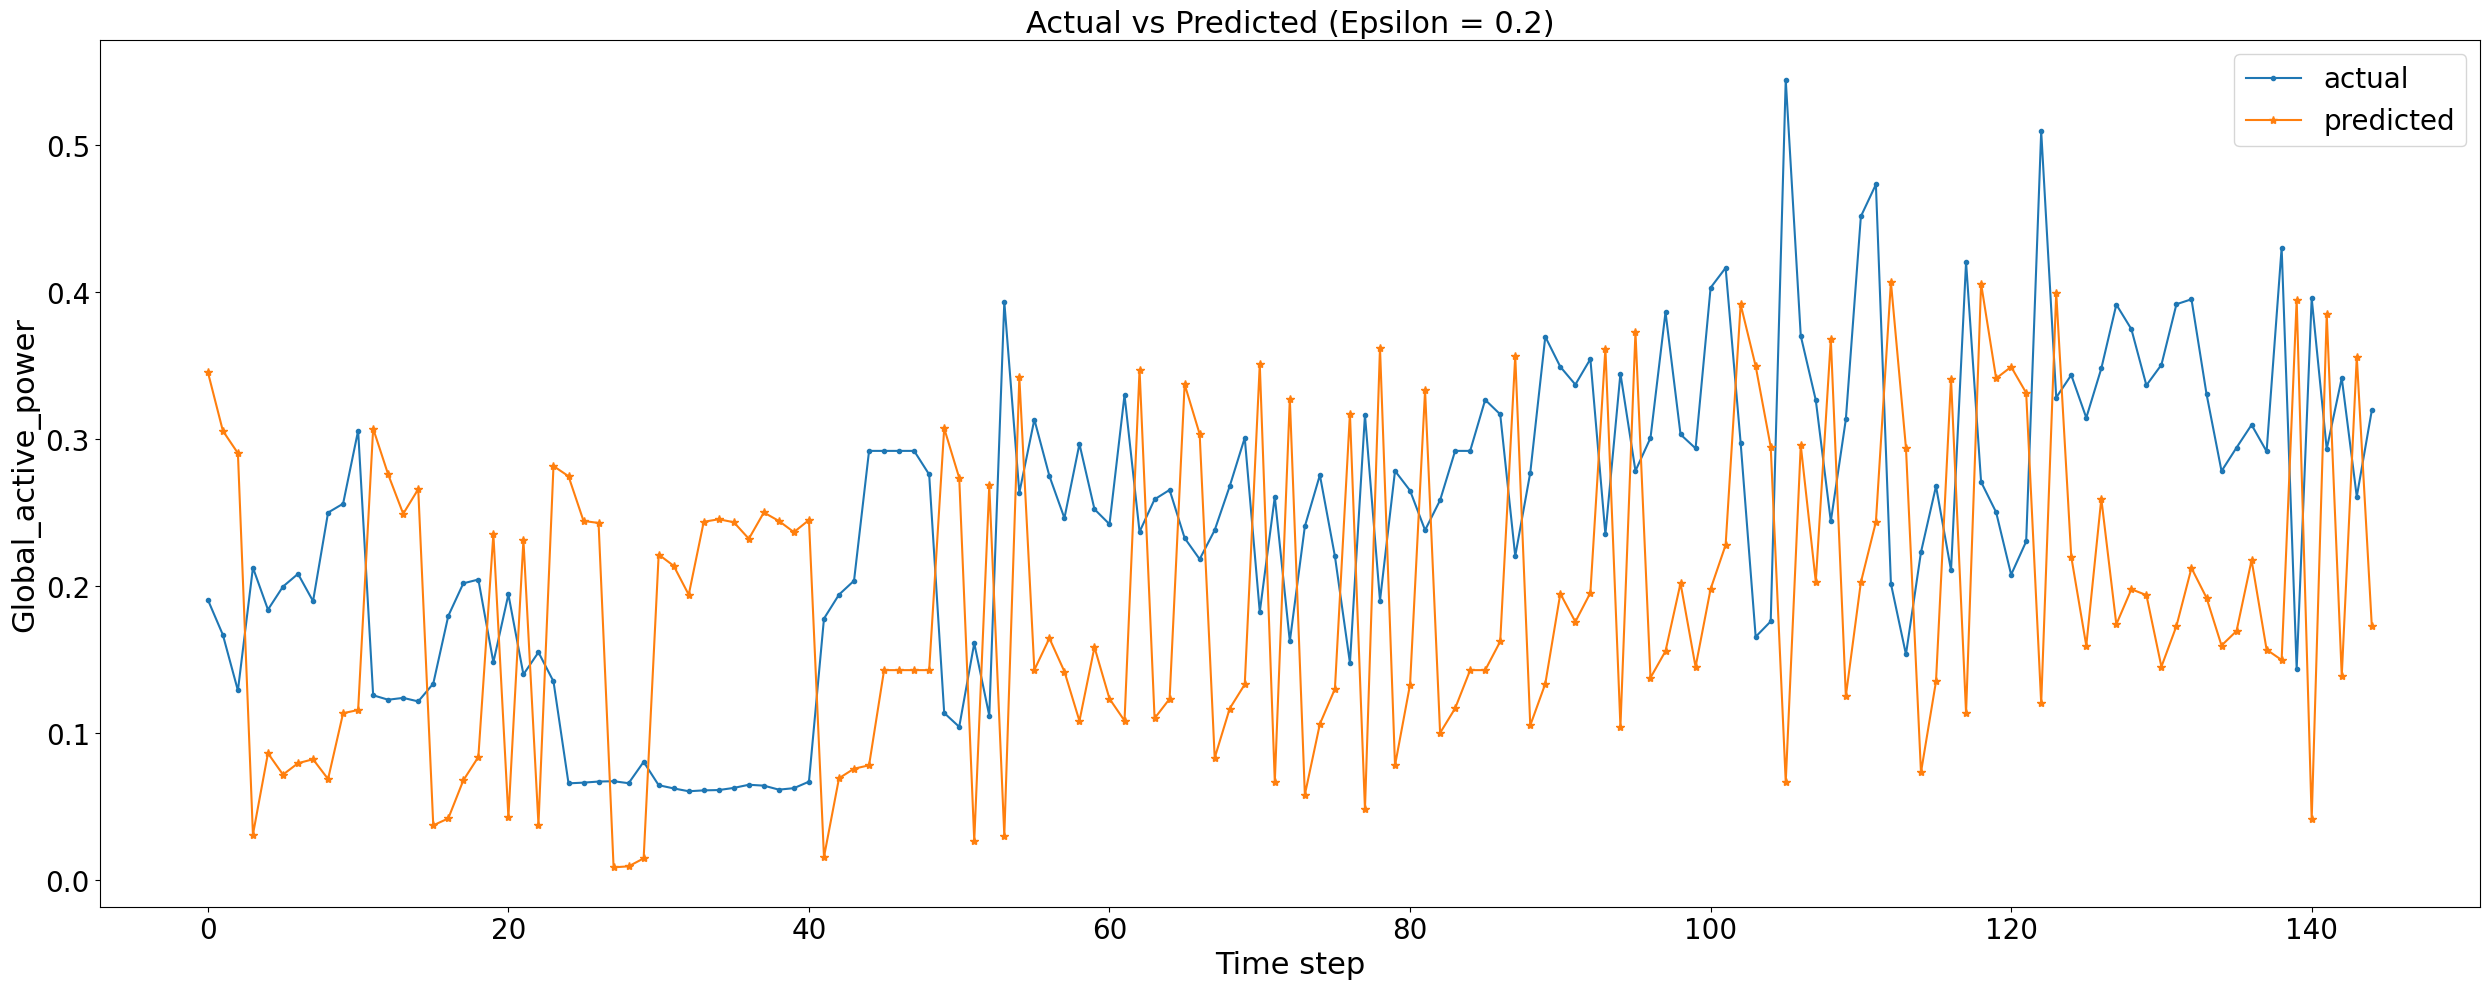

Running BIM attack with epsilon = 0.25


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis 3 of a tensor of shape (145, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


In [ ]:
# Define epsilon values to test
epsilon_values = [0.05, 0.1, 0.15, 0.2, 0.25]
attack_rmse = []
attack_mse = []
attacked_predictions = []

# Run BIM attack for each epsilon value
for epsilon in epsilon_values:
    print(f"Running BIM attack with epsilon = {epsilon}")

    # BIM attack with current epsilon
    advX_bim = bim_attack(robust_bim_model, test_X, test_y, epsilon)

    # Get predictions on adversarial examples
    test_pred_y = robust_bim_model.predict(advX_bim)
    attacked_predictions.append(test_pred_y)

    # Calculate RMSE
    mse = np.mean(np.square(test_y - test_pred_y))
    rmse = np.sqrt(mse)
    attack_rmse.append(rmse)
    attack_mse.append(mse)

    print(f"Epsilon: {epsilon}, RMSE: {rmse:.4f}, MSE: {mse:.4f}")

    # Plot individual attack results
    plt.figure(figsize=(25, 10))
    plt.ylabel('Global_active_power', fontsize=22)
    plt.xlabel('Time step', fontsize=22)
    plt.title(f"Actual vs Predicted (Epsilon = {epsilon})", fontsize=22)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.plot(range(len(test_y)), test_y[:], marker=".", label="actual")
    plt.plot(range(len(test_pred_y)), test_pred_y[:], marker="*", label="predicted")
    plt.legend(fontsize=20)
    plt.tight_layout()
    plt.savefig(f'transformer_bim_epsilon_{epsilon}.pdf', format='pdf')
    plt.show()

In [ ]:
# Plot RMSE vs Epsilon
plt.figure(figsize=(9, 9))
plt.ylabel('RMSE', fontsize=18)
plt.xlabel('Epsilon', fontsize=18)
plt.title("RMSE values for varying values of epsilon", fontsize=20)
plt.plot(epsilon_values, attack_rmse, marker=".", linewidth=2)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig('transformer_bim_rmse_vs_epsilon.pdf', format='pdf')
plt.show()

In [ ]:
# Compare effectiveness of different attacks
plt.figure(figsize=(15, 8))
plt.ylabel('MSE Loss', fontsize=18)
plt.xlabel('Model and Attack Type', fontsize=18)
plt.title("Attack Effectiveness Comparison", fontsize=20)
attack_results = [
    model.evaluate(test_X, test_y)[0],  # Standard model, clean data
    model.evaluate(advX, test_y)[0],    # Standard model, FGSM attack
    model.evaluate(advX_bim, test_y)[0], # Standard model, BIM attack
    robust_model.evaluate(test_X, test_y)[0],       # FGSM-robust model, clean data
    robust_model.evaluate(advX, test_y)[0],         # FGSM-robust model, FGSM attack
    robust_model.evaluate(advX_bim, test_y)[0],     # FGSM-robust model, BIM attack
    robust_bim_model.evaluate(test_X, test_y)[0],   # BIM-robust model, clean data
    robust_bim_model.evaluate(advX, test_y)[0],     # BIM-robust model, FGSM attack
    robust_bim_model.evaluate(advX_bim, test_y)[0]  # BIM-robust model, BIM attack
]
labels = [
    'Standard\nClean', 'Standard\nFGSM', 'Standard\nBIM',
    'FGSM-Robust\nClean', 'FGSM-Robust\nFGSM', 'FGSM-Robust\nBIM',
    'BIM-Robust\nClean', 'BIM-Robust\nFGSM', 'BIM-Robust\nBIM'
]
plt.bar(labels, attack_results)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
from IPython.display import display

# Collect all evaluation results
models = ["Standard Model", "FGSM-Robust Model", "BIM-Robust Model"]
test_scenarios = ["Clean Data", "FGSM Attack", "BIM Attack"]

# Create a dictionary with the results
results_dict = {
    "Standard Model": [
        model.evaluate(test_X, test_y)[0],  # Clean data
        model.evaluate(advX, test_y)[0],    # FGSM attack
        model.evaluate(advX_bim, test_y)[0] # BIM attack
    ],
    "FGSM-Robust Model": [
        robust_model.evaluate(test_X, test_y)[0],   # Clean data
        robust_model.evaluate(advX, test_y)[0],     # FGSM attack
        robust_model.evaluate(advX_bim, test_y)[0]  # BIM attack
    ],
    "BIM-Robust Model": [
        robust_bim_model.evaluate(test_X, test_y)[0],  # Clean data
        robust_bim_model.evaluate(advX, test_y)[0],    # FGSM attack
        robust_bim_model.evaluate(advX_bim, test_y)[0] # BIM attack
    ]
}

# Create a DataFrame
results_df = pd.DataFrame(results_dict, index=test_scenarios)

# Format the values to show 4 decimal places
results_df = results_df.applymap(lambda x: f"{x:.4f}")

# Display the table
print("Model Performance Comparison (MSE Loss)")
display(results_df)

# You can also create a table for the percentage increase in loss
base_results = [model.evaluate(test_X, test_y)[0]] * 3  # Base loss for standard model on clean data

# Calculate percentage change compared to clean data for each model
pct_change = {}
for model_name in models:
    base = float(results_dict[model_name][0])  # Clean data loss
    pct_change[model_name] = [
        "0.00%",  # Clean data (reference)
        f"{((float(results_dict[model_name][1]) / base) - 1) * 100:.2f}%",  # FGSM
        f"{((float(results_dict[model_name][2]) / base) - 1) * 100:.2f}%"   # BIM
    ]

# Create percentage change DataFrame
pct_change_df = pd.DataFrame(pct_change, index=test_scenarios)

# Display the table
print("\nPercentage Increase in Loss Compared to Clean Data")
display(pct_change_df)